# Sample Cost and Usage Analysis

This notebook provides:  
- A correlation analysis of various services,
    - the assumption being that the usage (and hence the cost) of related services will grow proportionally (direct or inverse)
- A time-series prediction of the costs incurred by a specific service
    - cost projections for the service for the next few days (or other periodic cycles based on input data)
    - the further away we get from the last available data (actuals) the less accurate the prediction, this is seen in the seasonality components.

### Setup and Imports

In [1]:
# Importing libraries
import os
import glob
import time

from IPython.display import display, HTML

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
import seaborn as sn
from prophet import Prophet
from scipy.stats import pearsonr

pio.renderers.default = "iframe"
pd.set_option("display.max_columns", None)

#### Check the directory for the files

In [2]:
# !dir .\may08\daily /b

#### define the list of files that will be processed in this notebook

In [3]:
# list of files
# KIAL-PROD-Hourly.csv
# KMBL-811-PROD-Hourly.csv
# KMBL-Logs-Hourly.csv
# KMBL-MB2-Hourly.csv
# KMBL-OU-Hourly.csv
# kmbl-prod-data-analytics-platform-Hourly.csv
# KMBL-PROD-Hourly.csv

# filepath = "./may07/hourly/"
filepath = "./may08/daily/"
# print(os.listdir(filepath))
all_files = os.listdir(filepath)
# filelist = glob.glob('./'+filepath+'/*.csv')
csv_files = [item for item in all_files if item.endswith('.csv')]
print(all_files)
filelist = csv_files
filelist

['.ipynb_checkpoints', 'KIAL-PROD-Daily.csv', 'KMBL-811-PROD-Daily.csv', 'KMBL-Logs-Daily.csv', 'KMBL-MB2-PROD-Daily.csv', 'KMBL-OU-Daily.csv', 'KMBL-PROD-Daily.csv', 'output']


['KIAL-PROD-Daily.csv',
 'KMBL-811-PROD-Daily.csv',
 'KMBL-Logs-Daily.csv',
 'KMBL-MB2-PROD-Daily.csv',
 'KMBL-OU-Daily.csv',
 'KMBL-PROD-Daily.csv']

## Helper functions

In [4]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [5]:
# collapse all cleanup in a single method
def prep_data(df):
    r = df.fillna(0)[1:]
    r.rename(columns={"Service": "date-time"}, inplace=True)
    r["date-time"] = pd.to_datetime(r["date-time"])
    r.index = r["date-time"]
    # print(type(r))
    return r

In [6]:
# calculate volatility (basically Coefficient of Variation as percentage)
# std = pd.DataFrame(cur_summary.loc['std'])
# mean = pd.DataFrame(cur_summary.loc['mean'])
# assumes the two dataframes have identical indices and shapes, returns a dataframe
def compute_volatility(std, mean):
    v = std.join(mean)
    v["volatility"] = (v["std"] / v["mean"]) * 100
    v.sort_values(by="volatility", inplace=True, ascending=False)
    return v

In [7]:
def drop_totals_and_reindex(df):
    df.drop(["Total costs($)"], axis=1)
    df = df.reindex(
        columns=[
            "date-time",
            "EC2-Instances($)",
            "S3($)",
            "Relational Database Service($)",
            "EC2-Other($)",
            "Glue($)",
            "DocumentDB (with MongoDB compatibility)($)",
            "Elastic MapReduce($)",
            "CloudWatch($)",
            "VPC($)",
            "OpenSearch Service($)",
            "Redshift($)",
            "Managed Streaming for Apache Kafka($)",
            "SageMaker($)",
            "ElastiCache($)",
            "DMS($)",
            "Elastic Load Balancing($)",
            "QuickSight($)",
            "Elastic File System($)",
            "SNS($)",
            "Lambda($)",
            "Elastic Container Service for Kubernetes($)",
            "Rekognition($)",
            "Hardened Red Hat Enterprise 7 (RHEL 7)($)",
            "Step Functions($)",
            "Glacier($)",
            "DynamoDB($)",
            "Backup($)",
            "AppFlow($)",
            "Route 53($)",
            "SQS($)",
            "EC2 Container Registry (ECR)($)",
            "Key Management Service($)",
            "API Gateway($)",
            "CloudFront($)",
            "Athena($)",
            "Secrets Manager($)",
            "CloudWatch Events($)",
            "Cognito($)",
            "X-Ray($)",
            "Cost Explorer($)",
            "Service Catalog($)",
            "Systems Manager($)",
            "SES($)",
            "Simple Workflow Service($)",
            "Direct Connect($)",
            "CloudTrail($)",
            "CodeArtifact($)",
            "Elastic Container Service($)",
            "Migration Hub Refactor Spaces($)",
            "Location Service($)",
        ]
    )
    return df

In [8]:
# Import the csv and convert to dataframe.
# fill all na to 0, ignore the summation row
percentiles = [i / 10 for i in range(10)][1:]


def process_data():
    d = {}
    for filename in filelist:
        cur_data_raw = pd.read_csv(filepath + filename)
        cur_data = prep_data(cur_data_raw)
        # print(type(cur_data))
        cur_summary = cur_data.describe(percentiles=percentiles)
        # print(type(cur_summary))
        volatility = compute_volatility(
            pd.DataFrame(cur_summary.loc["std"]),
            pd.DataFrame(cur_summary.loc["mean"]),
        )
        cur_data_simple = drop_totals_and_reindex(cur_data)
        # correlation - higher is more correlated
        cur_rho = cur_data_simple.corr(method="pearson", min_periods=3)
        # p-value - lower is surer
        curr_pval = cur_data_simple.corr(
            method=lambda x, y: pearsonr(x, y)[1]
        ) - np.eye(*cur_rho.shape)
        cur_corr_p_star = curr_pval.map(
            lambda x: "".join(
                [
                    "*"
                    for t in [
                        0.05,
                        0.01,
                        0.001,
                        0.00001,
                        0.0000001,
                        0.000000001,
                        0.00000000001,
                    ]
                    if x <= t
                ]
            )
        )
        cur_corr_p_rank = cur_corr_p_star.map(lambda x: len(x))
        cur_heatmap_rho = go.Figure(
            data=go.Heatmap(
                z=cur_rho,
                zmin=0.61,
                x=cur_rho.columns,
                y=cur_rho.index,
                colorscale="Earth",
                xgap=2,
                ygap=2,
            )
        )
        cur_heatmap_rho.update_layout(
            autosize=False, width=2040, height=2040
        )
        cur_heatmap_rank = go.Figure(
            data=go.Heatmap(
                z=cur_corr_p_rank,
                zmin=3,
                x=cur_corr_p_rank.columns,
                y=cur_corr_p_rank.index,
                colorscale="Earth",
                xgap=2,
                ygap=2,
            )
        )
        cur_heatmap_rank.update_layout(
            autosize=False, width=2040, height=2040
        )
        d[filename] = {
            "cur_data_raw": cur_data_raw,
            "cur_data": cur_data,
            "cur_summary": cur_summary,
            "volatility": volatility,
            "cur_data_simple": cur_data_simple,
            "cur_rho": cur_rho,
            "curr_pval": curr_pval,
            "cur_corr_p_star": cur_corr_p_star,
            "cur_corr_p_rank": cur_corr_p_rank,
            "cur_heatmap_rho": cur_heatmap_rho,
            "cur_heatmap_rank": cur_heatmap_rank,
        }
    for filename in filelist:
        for key in d[filename]:
            if key != "cur_heatmap_rho" and key != "cur_heatmap_rank":
                full_output_file_name = str(filename)+"_"+str(key)+".csv"
                d[filename][key].to_csv(filepath+"/output/"+full_output_file_name, encoding='utf-8')
            
    return d

### Process / Pre-compute the data    
This may be compute intensive, use at least 16GB RAM

In [ ]:
# process all the files and store the analysis in the dictionary res
res = process_data()

# Analysis of Cost and Usage Data

## Components of each analysis:
- "cur_data_raw" - raw data from the file    
- "cur_data" - clean data    
- "cur_summary" - .describe() with 10 percentiles    
- "volatility" - std/mean as a percentage value    
- "cur_data_simple" - remove total costs as well    
- "cur_rho" - correlation matrix across all services    
- "curr_pval" - p-values over the correlation     
- "cur_corr_p_star" - STAR (*) representation of correlations based on p-values for easier visual comparision       
- "cur_corr_p_rank" - simple RANK based representation of correlations based on p-values for easier analysis     
- "cur_heatmap_rho" - plotly graph object for plotting the heatmap based on raw correlations    
- "cur_heatmap_rank" - plotly graph object for plotting the heatmap based on curr_corr_p_rank

### Summary

In [10]:
component_description = {
    "cur_data_raw": "raw data from the file",  
    "cur_data": "clean data",  
    "cur_summary": ".describe() with 10 percentiles",  
    "volatility": "std/mean as a percentage value",  
    "cur_data_simple": "remove total costs as well",  
    "cur_rho": "correlation matrix across all services",  
    "curr_pval": "p-values over the correlation ",  
    "cur_corr_p_star": "STAR (*) representation of correlations based on p-values for easier visual comparision",  
    "cur_corr_p_rank": "simple RANK based representation of correlations based on p-values for easier analysis",  
    "cur_heatmap_rho": "plotly graph object for plotting the heatmap based on raw correlations",  
    "cur_heatmap_rank": "plotly graph object for plotting the heatmap based on curr_corr_p_rank"
}

def show_analysis_for_file(k):
    display(HTML('<h2 style="color:blue;"><br/><br/><hr/><br/></h2>'))
    display(HTML('<h1 style="color:blue;">Analysis for <b>'+k+'</b><br/></h1>'))
    for df in res[k]:
        if df != "cur_heatmap_rho" and df != "cur_heatmap_rank":
            time.sleep(1)
            display(HTML('<h2 style="color:blue;"><br/><br/><br/></h2>'))
            display(HTML('<h2 style="color:tomato;"<b>'+k+'</b><br/>'+'</h2>'+'<h3 style="color:blue;">'+component_description[df]+'</h3>'))
            # print ('\n\n\n\n'+component_description[df])
            if df == "cur_summary":
                display(res[k][df])
            else:
                display(res[k][df].head())
        else:
            if df == "cur_heatmap_rho":
                time.sleep(2)
                msg = "raw correlations of service usage" # for: "+k
                display(HTML('<h2 style="color:blue;"><br/><br/><br/></h2>'))
                display(HTML('<h2 style="color:tomato;"<b>'+k+'</b><br/>'+'</h2>'+'<h3 style="color:blue;">'+msg+'</h3>'))
                # print('\n\n\n\n'+"raw correlations of service usage for: ",k)
            elif df == "cur_heatmap_rank":
                time.sleep(2)
                msg = "statistical significance of usage correlations between services:" # for: "+k
                display(HTML('<h2 style="color:blue;"><br/><br/><br/></h2>'))
                display(HTML('<h2 style="color:tomato;"<b>'+k+'</b><br/>'+'</h2>'+'<h3 style="color:blue;">'+msg+'</h3>'))
                # print('\n\n\n\n'+"statistical significance of usage correlations between services for: ",k)
            res[k][df].show()

In [11]:
# cmd_list = []
# for k in res.keys():
#     for df in res[k]:
#         if df != "cur_heatmap_rho" and df != "cur_heatmap_rank":
#             cmd_list.append(str("res["+k+"]["+df+"].head()"))
#         else:
#             cmd_list.append(str("res["+k+"]["+df+"].show()"))
# cmd_list

In [12]:
print(filelist)

['KIAL-PROD-Daily.csv', 'KMBL-811-PROD-Daily.csv', 'KMBL-Logs-Daily.csv', 'KMBL-MB2-PROD-Daily.csv', 'KMBL-OU-Daily.csv', 'KMBL-PROD-Daily.csv']


In [13]:
# replace the filename from the list above to see the respective summary
# res["KMBL-PROD-Daily.csv"]["cur_summary"].head()

In [14]:
# replace the filename from the list above to see the respective volatility data
# res["KMBL-PROD-Daily.csv"]["volatility"]

In [15]:
# replace the filename from the list above to see the respective heatmap
#
# uncomment the right line to see the relevant heatmap
# print("raw correlations of service usage for KMBL-PROD-Daily")
# res["KMBL-PROD-Daily.csv"]["cur_heatmap_rho"].show()

In [16]:
# print("statistical significance of usage correlations between services for KMBL-PROD-Daily")
# res['KMBL-PROD-Daily.csv']['cur_heatmap_rank'].show()

In [17]:
for f in filelist:
    print(f)
    time.sleep(1) #give it time to render...
    show_analysis_for_file(f)

KIAL-PROD-Daily.csv


,Service,Relational Database Service($),Tax($),Savings Plans for Compute usage($),EC2-Other($),Support (Business)($),VPC($),OpenSearch Service($),CloudWatch($),EC2-Instances($),ElastiCache($),S3($),DocumentDB (with MongoDB compatibility)($),Managed Streaming for Apache Kafka($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Glacier($),SES($),EC2 Container Registry (ECR)($),Elastic Container Service for Kubernetes($),Elastic Load Balancing($),CloudTrail($),Key Management Service($),CloudFront($),SageMaker($),Rekognition($),DynamoDB($),Cost Explorer($),Lambda($),Secrets Manager($),SQS($),SNS($),Route 53($),Service Catalog($),Glue($),Athena($),Direct Connect($),Config($),AppFlow($),Systems Manager($),Simple Workflow Service($),Step Functions($),CloudShell($),Elastic File System($),CodeArtifact($),Backup($),Migration Hub Refactor Spaces($),Location Service($),Refund($),Total costs($)
0,Service total,120149.249144,53966.15,47172.27,28937.402698,25295.283089,15484.026643,14678.138571,13463.431361,7711.956590,6461.472271,5905.887695,4778.710281,3745.527321,3191.18,1426.313268,1273.831776,1155.951892,942.57834,878.612568,784.828295,502.473721,322.606411,275.000024,132.036362,41.501888,30.0102,13.782509,10.144469,3.495181,2.788037,1.664,1.226673,0.214189,0.141369,0.036103,0.01302,0.004534,0.000435,0.00028,2.797970e-04,0.000037,0.000007,4.605000e-07,3.840000e-08,0.0,0.0,-1770.67,356969.271532
1,2023-04-01,301.203781,3840.25,NaN,86.970440,1941.664303,59.326484,6.986076,14.176990,206.308227,1.071360,31.520309,6.732272,NaN,9.12,11.531895,2.322588,0.032306,2.23200,2.254594,2.201506,5.924474,0.035126,NaN,0.044175,0.099101,NaN,0.014418,0.002669,0.012075,0.006066,NaN,NaN,0.001667,NaN,NaN,0.01302,NaN,NaN,NaN,8.640000e-07,NaN,NaN,4.400000e-08,NaN,NaN,NaN,-135.92,6396.137926
2,2023-04-02,301.203781,NaN,NaN,86.823475,NaN,58.967452,6.986075,15.039071,206.308226,1.071360,31.369553,6.731861,NaN,9.12,11.603962,2.321190,0.032306,2.23200,2.241766,2.170469,5.917377,0.028114,NaN,0.006975,0.099101,NaN,0.020082,0.002925,0.012056,0.011760,NaN,NaN,0.001875,NaN,NaN,NaN,NaN,NaN,NaN,9.132000e-07,NaN,NaN,5.280000e-08,NaN,NaN,NaN,NaN,750.322814
3,2023-04-03,301.203781,NaN,NaN,86.802266,NaN,57.031061,6.986075,15.212474,206.318386,1.071360,31.477501,6.731977,NaN,9.12,11.684711,2.322598,0.033704,2.23200,2.303296,2.190120,5.936798,0.080835,2.699241,0.019762,0.099101,NaN,0.024352,0.002674,0.012197,0.011759,NaN,NaN,0.001839,NaN,NaN,NaN,NaN,NaN,NaN,8.779000e-07,NaN,NaN,6.160000e-08,NaN,NaN,NaN,NaN,751.609867
4,2023-04-04,301.203781,NaN,NaN,86.801195,NaN,56.492137,6.986075,15.000316,206.308225,1.071360,31.115921,6.731985,NaN,9.12,11.762752,2.323184,0.034430,2.23200,2.257132,2.143892,5.921255,0.038309,2.699337,0.010462,0.099101,NaN,0.022884,0.002590,0.012190,0.011657,NaN,NaN,0.001728,NaN,NaN,NaN,NaN,NaN,NaN,8.162000e-07,NaN,NaN,4.400000e-08,NaN,NaN,NaN,NaN,750.403899


,date-time,Relational Database Service($),Tax($),Savings Plans for Compute usage($),EC2-Other($),Support (Business)($),VPC($),OpenSearch Service($),CloudWatch($),EC2-Instances($),ElastiCache($),S3($),DocumentDB (with MongoDB compatibility)($),Managed Streaming for Apache Kafka($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Glacier($),SES($),EC2 Container Registry (ECR)($),Elastic Container Service for Kubernetes($),Elastic Load Balancing($),CloudTrail($),Key Management Service($),CloudFront($),SageMaker($),Rekognition($),DynamoDB($),Cost Explorer($),Lambda($),Secrets Manager($),SQS($),SNS($),Route 53($),Service Catalog($),Glue($),Athena($),Direct Connect($),Config($),AppFlow($),Systems Manager($),Simple Workflow Service($),Step Functions($),CloudShell($),Elastic File System($),CodeArtifact($),Backup($),Migration Hub Refactor Spaces($),Location Service($),Refund($),Total costs($)
date-time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-01,2023-04-01,301.203781,3840.25,0.0,86.970440,1941.664303,59.326484,6.986076,14.176990,206.308227,1.07136,31.520309,6.732272,0.0,9.12,11.531895,2.322588,0.032306,2.232,2.254594,2.201506,5.924474,0.035126,0.000000,0.044175,0.099101,0.0,0.014418,0.002669,0.012075,0.006066,0.0,0.0,0.001667,0.0,0.0,0.01302,0.0,0.0,0.0,8.640000e-07,0.0,0.0,4.400000e-08,0.0,0.0,0.0,-135.92,6396.137926
2023-04-02,2023-04-02,301.203781,0.00,0.0,86.823475,0.000000,58.967452,6.986075,15.039071,206.308226,1.07136,31.369553,6.731861,0.0,9.12,11.603962,2.321190,0.032306,2.232,2.241766,2.170469,5.917377,0.028114,0.000000,0.006975,0.099101,0.0,0.020082,0.002925,0.012056,0.011760,0.0,0.0,0.001875,0.0,0.0,0.00000,0.0,0.0,0.0,9.132000e-07,0.0,0.0,5.280000e-08,0.0,0.0,0.0,0.00,750.322814
2023-04-03,2023-04-03,301.203781,0.00,0.0,86.802266,0.000000,57.031061,6.986075,15.212474,206.318386,1.07136,31.477501,6.731977,0.0,9.12,11.684711,2.322598,0.033704,2.232,2.303296,2.190120,5.936798,0.080835,2.699241,0.019762,0.099101,0.0,0.024352,0.002674,0.012197,0.011759,0.0,0.0,0.001839,0.0,0.0,0.00000,0.0,0.0,0.0,8.779000e-07,0.0,0.0,6.160000e-08,0.0,0.0,0.0,0.00,751.609867
2023-04-04,2023-04-04,301.203781,0.00,0.0,86.801195,0.000000,56.492137,6.986075,15.000316,206.308225,1.07136,31.115921,6.731985,0.0,9.12,11.762752,2.323184,0.034430,2.232,2.257132,2.143892,5.921255,0.038309,2.699337,0.010462,0.099101,0.0,0.022884,0.002590,0.012190,0.011657,0.0,0.0,0.001728,0.0,0.0,0.00000,0.0,0.0,0.0,8.162000e-07,0.0,0.0,4.400000e-08,0.0,0.0,0.0,0.00,750.403899
2023-04-05,2023-04-05,301.203781,0.00,0.0,86.977722,0.000000,56.658028,6.986075,15.445492,214.741861,1.07136,31.132996,6.731889,0.0,9.12,11.839737,2.325630,0.034430,2.232,2.353091,2.162604,5.921958,0.063561,2.700063,0.067425,0.099101,0.0,0.035741,0.002344,0.011791,0.011525,0.0,0.0,0.001415,0.0,0.0,0.00000,0.0,0.0,0.0,6.906000e-07,0.0,0.0,5.280000e-08,0.0,0.0,0.0,0.00,759.931621


,date-time,Relational Database Service($),Tax($),Savings Plans for Compute usage($),EC2-Other($),Support (Business)($),VPC($),OpenSearch Service($),CloudWatch($),EC2-Instances($),ElastiCache($),S3($),DocumentDB (with MongoDB compatibility)($),Managed Streaming for Apache Kafka($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Glacier($),SES($),EC2 Container Registry (ECR)($),Elastic Container Service for Kubernetes($),Elastic Load Balancing($),CloudTrail($),Key Management Service($),CloudFront($),SageMaker($),Rekognition($),DynamoDB($),Cost Explorer($),Lambda($),Secrets Manager($),SQS($),SNS($),Route 53($),Service Catalog($),Glue($),Athena($),Direct Connect($),Config($),AppFlow($),Systems Manager($),Simple Workflow Service($),Step Functions($),CloudShell($),Elastic File System($),CodeArtifact($),Backup($),Migration Hub Refactor Spaces($),Location Service($),Refund($),Total costs($)
count,396,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,3.960000e+02,3.960000e+02,3.960000e+02,3.960000e+02,3.960000e+02,3.960000e+02,396.0,396.0,396.000000,396.000000
mean,2023-10-15 12:00:00,303.407195,136.278157,119.121894,73.074249,63.876977,39.101077,37.066006,33.998564,19.474638,16.316849,14.913858,12.067450,9.458402,8.058535,3.601801,3.216747,2.919070,2.380248,2.218719,1.981890,1.268873,0.814663,0.694445,0.333425,0.104803,0.075783,0.034804,0.025617,0.008826,0.007040,0.004202,0.003098,0.000541,0.000357,0.000091,0.000033,0.000011,0.000001,7.069980e-07,7.065581e-07,9.294394e-08,1.784823e-08,1.162879e-09,9.696970e-11,0.0,0.0,-4.471389,901.437554
min,2023-04-01 00:00:00,120.816049,0.000000,0.000000,62.986595,0.000000,26.643659,6.975248,14.176990,0.000000,1.071360,9.775415,6.731522,0.000000,6.200000,1.868012,2.245500,0.032306,2.112000,1.730315,0.000000,0.475842,0.012771,0.000000,0.005812,0.000000,0.000000,0.006037,0.000079,0.000796,0.000221,0.000000,0.000000,0.000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,-193.700000,510.604128
10%,2023-05-10 12:00:00,191.548329,0.000000,122.496000,65.292532,0.000000,27.678069,6.986103,21.273577,0.000000,13.838400,11.615096,6.732613,0.000000,6.470000,1.910467,2.326022,0.037416,2.232000,1.845853,0.000000,0.697785,0.205929,0.000000,0.065681,0.099101,0.000000,0.008084,0.000188,0.001284,0.003058,0.000000,0.000000,0.000098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,3.211000e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,589.975617
20%,2023-06-19 00:00:00,249.149761,0.000000,129.456000,66.220676,0.000000,29.541188,27.779265,24.536395,0.000000,13.838400,12.356708,12.695180,0.000000,6.720000,1.910467,2.541918,0.086688,2.232000,1.896201,0.000000,0.746357,0.269786,0.076800,0.133687,0.099101,0.000000,0.009716,0.000418,0.001509,0.003292,0.000000,0.000000,0.000135,0.000000,0.000000,0.000000,0.000000,0.000000,4.793000e-07,4.674000e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,636.629598
30%,2023-07-28 12:00:00,258.899365,0.000000,129.456000,67.159077,0.000000,30.924421,30.085360,27.949236,1.156701,13.838400,12.816227,13.412009,0.000000,7.670000,1.910467,2.787704,0.128919,2.232000,1.932674,0.000000,0.828872,0.314748,0.094759,0.181350,0.099101,0.000000,0.011810,0.001548,0.001601,0.003722,0.000000,0.000000,0.000171,0.000000,0.000000,0.000000,0.000000,0.000000,6.022000e-07,6.571000e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,652.322610
40%,2023-09-06 00:00:00,267.670932,0.000000,129.456000,68.135076,0.000000,34.596997,31.335975,30.555274,3.268869,13.838400,13.392276,13.412368,0.000000,7.

,std,mean,volatility
Systems Manager($),0.000022,0.000001,1989.974874
AppFlow($),0.000228,0.000011,1989.974874
Config($),0.000654,0.000033,1989.974874
Direct Connect($),0.001805,0.000091,1980.28024
Athena($),0.005452,0.000357,1527.122789


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-01,2023-04-01,206.308227,31.520309,301.203781,86.970440,0.001667,6.732272,NaN,14.176990,59.326484,6.986076,NaN,0.0,0.000000,1.07136,NaN,2.254594,NaN,0.0,0.006066,0.014418,2.232,0.044175,9.12,8.640000e-07,11.531895,0.099101,0.0,0.0,0.0,0.012075,0.032306,5.924474,NaN,0.035126,0.0,0.002669,NaN,NaN,NaN,0.0,0.0,0.0,2.322588,0.0,0.0,2.201506,4.400000e-08,NaN,0.0,0.0
2023-04-02,2023-04-02,206.308226,31.369553,301.203781,86.823475,0.001875,6.731861,NaN,15.039071,58.967452,6.986075,NaN,0.0,0.000000,1.07136,NaN,2.241766,NaN,0.0,0.011760,0.020082,2.232,0.006975,9.12,9.132000e-07,11.603962,0.099101,0.0,0.0,0.0,0.012056,0.032306,5.917377,NaN,0.028114,0.0,0.002925,NaN,NaN,NaN,0.0,0.0,0.0,2.321190,0.0,0.0,2.170469,5.280000e-08,NaN,0.0,0.0
2023-04-03,2023-04-03,206.318386,31.477501,301.203781,86.802266,0.001839,6.731977,NaN,15.212474,57.031061,6.986075,NaN,0.0,2.699241,1.07136,NaN,2.303296,NaN,0.0,0.011759,0.024352,2.232,0.019762,9.12,8.779000e-07,11.684711,0.099101,0.0,0.0,0.0,0.012197,0.033704,5.936798,NaN,0.080835,0.0,0.002674,NaN,NaN,NaN,0.0,0.0,0.0,2.322598,0.0,0.0,2.190120,6.160000e-08,NaN,0.0,0.0
2023-04-04,2023-04-04,206.308225,31.115921,301.203781,86.801195,0.001728,6.731985,NaN,15.000316,56.492137,6.986075,NaN,0.0,2.699337,1.07136,NaN,2.257132,NaN,0.0,0.011657,0.022884,2.232,0.010462,9.12,8.162000e-07,11.762752,0.099101,0.0,0.0,0.0,0.012190,0.034430,5.921255,NaN,0.038309,0.0,0.002590,NaN,NaN,NaN,0.0,0.0,0.0,2.323184,0.0,0.0,2.143892,4.400000e-08,NaN,0.0,0.0
2023-04-05,2023-04-05,214.741861,31.132996,301.203781,86.977722,0.001415,6.731889,NaN,15.445492,56.658028,6.986075,NaN,0.0,2.700063,1.07136,NaN,2.353091,NaN,0.0,0.011525,0.035741,2.232,0.067425,9.12,6.906000e-07,11.839737,0.099101,0.0,0.0,0.0,0.011791,0.034430,5.921958,NaN,0.063561,0.0,0.002344,NaN,NaN,NaN,0.0,0.0,0.0,2.325630,0.0,0.0,2.162604,5.280000e-08,NaN,0.0,0.0


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,1.000000,-0.279124,-0.180169,-0.125296,-0.800593,-0.655787,0.657661,NaN,0.481908,0.397149,-0.077097,NaN,0.864270,-0.586491,-0.285837,NaN,-0.721392,NaN,0.574590,-0.630913,0.151433,0.358682,0.494853,-0.917299,0.203569,-0.489601,0.583798,0.566517,0.086929,0.068971,-0.668071,0.086013,-0.262246,NaN,-0.375119,-0.018248,0.745620,NaN,NaN,NaN,0.273822,0.002062,0.028830,0.527355,0.437333,0.011270,-0.022601,-0.273828,NaN,NaN,NaN
EC2-Instances($),-0.279124,1.000000,0.580626,0.054310,0.420021,0.356307,-0.482478,NaN,-0.469155,0.221378,-0.137637,NaN,-0.282709,0.335752,-0.256905,NaN,0.063903,NaN,0.176906,0.110037,0.293897,-0.027182,-0.276662,0.149387,-0.100573,0.319683,0.139800,0.205097,0.074757,-0.034909,-0.000399,-0.127817,0.613325,NaN,-0.101601,-0.033611,-0.125002,NaN,NaN,NaN,-0.358252,0.033420,-0.017891,-0.299752,-0.386735,-0.027055,-0.129460,0.823009,NaN,NaN,NaN
S3($),-0.180169,0.580626,1.000000,-0.030120,0.119641,0.188364,-0.347440,NaN,-0.058189,0.591777,-0.270847,NaN,-0.052174,0.086526,-0.479436,NaN,-0.130143,NaN,0.054769,0.176840,-0.019170,-0.055717,-0.198167,0.075960,0.100907,0.192483,0.042790,0.072903,0.014534,-0.034490,0.015290,0.089193,0.952756,NaN,-0.172165,-0.019168,-0.067413,NaN,NaN,NaN,-0.051196,-0.108235,-0.035817,-0.213442,-0.378639,0.016298,0.209876,0.582265,NaN,NaN,NaN
Relational Database Service($),-0.125296,0.054310,-0.030120,1.000000,0.163712,0.156746,-0.047780,NaN,-0.095072,-0.110151,0.049657,NaN,-0.150812,0.166868,0.183269,NaN,0.088839,NaN,-0.048000,0.056836,0.067730,-0.065593,-0.076484,0.107106,-0.037955,0.033670,-0.057308,-0.037670,-0.002195,-0.008105,0.058153,-0.024952,-0.010622,NaN,0.028748,-0.001599,-0.100120,NaN,NaN,NaN,-0.094538,0.165516,-0.004426,-0.057347,0.036459,-0.004752,-0.051976,-0.003151,NaN,NaN,NaN
EC2-Other($),-0.800593,0.420021,0.119641,0.163712,1.000000,0.664432,-0.541742,NaN,-0.579678,-0.464257,0.134156,NaN,-0.776920,0.609105,0.398036,NaN,0.722816,NaN,-0.360300,0.410114,0.116967,-0.228357,-0.447827,0.736321,-0.244911,0.334065,-0.395014,-0.358533,-0.051522,-0.059007,0.491623,-0.183541,0.227113,NaN,0.410709,-0.005881,-0.576891,NaN,NaN,NaN,-0.421669,0.123972,-0.038814,-0.405172,-0.311169,-0.033650,-0.210393,0.300743,NaN,NaN,NaN


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,0.000000e+00,1.607992e-08,3.139402e-04,0.012584,1.163474e-89,4.837683e-50,2.056109e-50,NaN,2.029196e-24,2.057978e-16,1.256131e-01,NaN,1.242089e-119,5.851945e-38,6.981236e-09,NaN,7.530583e-65,NaN,3.626269e-36,2.373850e-45,2.516098e-03,1.818601e-13,7.503613e-26,1.203448e-159,4.484631e-05,2.908769e-25,1.511384e-37,5.421620e-35,0.084047,0.170750,1.584541e-52,0.087378,1.189597e-07,NaN,1.117899e-14,0.717345,1.882115e-71,NaN,NaN,NaN,3.060125e-08,0.967377,0.567316,9.969002e-30,6.264503e-20,0.823092,0.653876,3.058103e-08,NaN,NaN,NaN
EC2-Instances($),1.607992e-08,0.000000e+00,4.568477e-37,0.280978,2.344052e-18,2.685854e-13,1.760186e-24,NaN,4.568515e-23,8.718453e-06,6.081507e-03,NaN,1.032698e-08,6.866199e-12,2.178378e-07,NaN,2.044681e-01,NaN,4.044047e-04,2.856446e-02,2.489122e-09,5.896712e-01,2.171849e-08,2.881483e-03,4.548773e-02,7.356491e-11,5.321663e-03,3.917674e-05,0.137538,0.488504,9.936882e-01,0.010899,2.772059e-42,NaN,4.331251e-02,0.504814,1.279552e-02,NaN,NaN,NaN,1.952248e-13,0.507247,0.722639,1.153024e-09,1.412054e-15,0.591414,0.009911,8.125309e-99,NaN,NaN,NaN
S3($),3.139402e-04,4.568477e-37,0.000000e+00,0.550090,1.722494e-02,1.630140e-04,1.119327e-12,NaN,2.479841e-01,8.857771e-39,4.364852e-08,NaN,3.003588e-01,8.549923e-02,3.748938e-24,NaN,9.523722e-03,NaN,2.769196e-01,4.064536e-04,7.037102e-01,2.686812e-01,7.173434e-05,1.313043e-01,4.477186e-02,1.160331e-04,3.957655e-01,1.475889e-01,0.773106,0.493735,7.616433e-01,0.076256,5.349379e-206,NaN,5.797240e-04,0.703751,1.806438e-01,NaN,NaN,NaN,3.095139e-01,0.031290,0.477249,1.839989e-05,6.023759e-15,0.746444,0.000026,2.583172e-37,NaN,NaN,NaN
Relational Database Service($),1.258446e-02,2.809779e-01,5.500902e-01,0.000000,1.076945e-03,1.755749e-03,3.429557e-01,NaN,5.873049e-02,2.839941e-02,3.243062e-01,NaN,2.622344e-03,8.575070e-04,2.458119e-04,NaN,7.743249e-02,NaN,3.407297e-01,2.591693e-01,1.785947e-01,1.927242e-01,1.286526e-01,3.310684e-02,4.513448e-01,5.040753e-01,2.552309e-01,4.547535e-01,0.965262,0.872274,2.482753e-01,0.620573,8.331167e-01,NaN,5.684124e-01,0.974700,4.647403e-02,NaN,NaN,NaN,6.016904e-02,0.000946,0.930030,2.549014e-01,4.693901e-01,0.924897,0.302195,9.501586e-01,NaN,NaN,NaN
EC2-Other($),1.163474e-89,2.344052e-18,1.722494e-02,0.001077,0.000000e+00,8.878452e-52,1.394918e-31,NaN,6.343182e-37,1.459846e-22,7.510478e-03,NaN,3.500272e-81,1.413661e-41,1.741278e-16,NaN,3.222282e-65,NaN,1.391701e-13,1.698884e-17,1.989902e-02,4.418288e-06,6.288799e-21,7.850444e-69,8.072695e-07,8.865057e-12,3.071901e-16,1.863753e-13,0.306446,0.241381,1.731064e-25,0.000241,4.995058e-06,NaN,1.510960e-17,0.907124,1.654515e-36,NaN,NaN,NaN,1.675368e-18,0.013559,0.441164,4.453426e-17,2.444608e-10,0.504324,0.000024,1.010406e-09,NaN,NaN,NaN


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,*******,*****,***,*,*******,*******,*******,,*******,*******,,,*******,*******,*****,,*******,,*******,*******,**,*******,*******,*******,***,*******,*******,*******,,,*******,,****,,*******,,*******,,,,*****,,,*******,*******,,,*****,,,
EC2-Instances($),*****,*******,*******,,*******,*******,*******,,*******,****,**,,*****,*******,****,,,,***,*,*****,,*****,**,*,******,**,***,,,,*,*******,,*,,*,,,,*******,,,*****,*******,,**,*******,,,
S3($),***,*******,*******,,*,***,*******,,,*******,*****,,,,*******,,**,,,***,,,***,,*,***,,,,,,,*******,,***,,,,,,,*,,***,*******,,***,*******,,,
Relational Database Service($),*,,,*******,**,**,,,,*,,,**,***,***,,,,,,,,,*,,,,,,,,,,,,,*,,,,,***,,,,,,,,,
EC2-Other($),*******,*******,*,**,*******,*******,*******,,*******,*******,**,,*******,*******,*******,,*******,,*******,*******,*,****,*******,*******,****,*******,*******,*******,,,*******,***,****,,*******,,*******,,,,*******,*,,*******,******,,***,*****,,,


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,7,5,3,1,7,7,7,0,7,7,0,0,7,7,5,0,7,0,7,7,2,7,7,7,3,7,7,7,0,0,7,0,4,0,7,0,7,0,0,0,5,0,0,7,7,0,0,5,0,0,0
EC2-Instances($),5,7,7,0,7,7,7,0,7,4,2,0,5,7,4,0,0,0,3,1,5,0,5,2,1,6,2,3,0,0,0,1,7,0,1,0,1,0,0,0,7,0,0,5,7,0,2,7,0,0,0
S3($),3,7,7,0,1,3,7,0,0,7,5,0,0,0,7,0,2,0,0,3,0,0,3,0,1,3,0,0,0,0,0,0,7,0,3,0,0,0,0,0,0,1,0,3,7,0,3,7,0,0,0
Relational Database Service($),1,0,0,7,2,2,0,0,0,1,0,0,2,3,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,0,0
EC2-Other($),7,7,1,2,7,7,7,0,7,7,2,0,7,7,7,0,7,0,7,7,1,4,7,7,4,7,7,7,0,0,7,3,4,0,7,0,7,0,0,0,7,1,0,7,6,0,3,5,0,0,0


KMBL-811-PROD-Daily.csv


,Service,EC2-Other($),Tax($),Glue($),S3($),Support (Business)($),CloudWatch($),Savings Plans for Compute usage($),Relational Database Service($),Cognito($),CloudFront($),CloudTrail($),EC2-Instances($),ElastiCache($),MQ($),VPC($),Managed Streaming for Apache Kafka($),Systems Manager($),OpenSearch Service($),Elastic Load Balancing($),Elastic Container Service for Kubernetes($),DynamoDB($),DocumentDB (with MongoDB compatibility)($),Certificate Manager($),Route 53($),API Gateway($),QuickSight($),EC2 Container Registry (ECR)($),Hardened Red Hat Enterprise 7 (RHEL 7)($),CIS Linux 2 Benchmark - Level 2($),CIS Ubuntu Linux 20.04 LTS Benchmark - Level 1($),Redshift($),DMS($),Elastic MapReduce($),Key Management Service($),SQS($),Managed Workflows for Apache Airflow($),WAF($),Kinesis($),Lambda($),Kinesis Firehose($),Athena($),Secrets Manager($),Cost Explorer($),SNS($),CIS Ubuntu Linux 22.04 LTS Benchmark - Level 1($),Service Catalog($),SES($),Direct Connect($),CloudWatch Events($),Budgets($),Config($),Glacier($),Simple Workflow Service($),Step Functions($),X-Ray($),CloudShell($),CodeArtifact($),Refund($),Total costs($)
0,Service total,193284.321640,132010.51,129859.257826,68138.579059,56276.346847,49996.793718,39771.45,29962.137024,22295.181973,21374.724644,16185.221464,15779.489904,13657.983885,13259.909678,12878.287565,8195.961984,6943.254958,6685.862157,5129.407550,4419.36,4294.952613,3793.213126,2748.329817,2355.137698,2321.175147,2178.245987,1568.805613,1147.22,796.996,599.756,516.38521,510.001822,481.262326,465.349951,415.349101,368.308032,338.463697,223.3836,214.470139,196.008022,131.528533,57.032883,29.9181,25.736589,4.40,3.242631,7.155073e-01,0.193417,0.041055,0.0093,0.00465,0.000684,0.000184,1.702688e-04,0.000043,0.000036,4.916000e-07,-3939.33,867950.349562
1,2023-04-01,459.141194,9477.68,163.449675,152.571055,3984.291337,61.207821,111.60,33.982042,NaN,0.010805,14.497975,124.521967,22.632480,23.125385,24.450268,NaN,6.510000,17.060324,8.248101,11.16,0.000000,2.578341,NaN,0.186000,0.002065,6.696000,1.037406,2.88,0.480,0.480,NaN,NaN,NaN,0.653157,0.000755,NaN,0.186000,NaN,0.029955,0.030622,NaN,0.053697,NaN,0.002425,0.46,NaN,NaN,NaN,NaN,NaN,0.00465,0.000002,NaN,8.654000e-07,NaN,NaN,5.280000e-08,-278.90,14433.001504
2,2023-04-02,461.683472,NaN,194.116625,153.670462,NaN,62.029757,111.60,33.983080,NaN,0.006743,14.476194,125.064384,22.632480,23.124473,17.765903,NaN,NaN,17.060324,8.133072,11.16,0.000000,2.576981,NaN,NaN,0.000109,6.696000,1.037406,2.88,0.480,0.480,NaN,NaN,NaN,0.653606,0.000787,NaN,0.186000,NaN,0.047450,0.030587,NaN,0.053892,NaN,0.014940,0.48,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN,8.982000e-07,NaN,NaN,5.420000e-08,NaN,1272.124728
3,2023-04-03,467.740160,NaN,351.559010,207.749209,NaN,72.756228,111.60,33.982773,NaN,0.014412,15.576496,125.123743,22.632480,23.125312,16.269905,NaN,NaN,17.060323,8.314704,11.16,0.000143,2.579946,NaN,NaN,0.001115,6.696000,1.038382,2.88,0.500,0.480,NaN,NaN,NaN,0.682136,0.000796,NaN,0.186000,NaN,0.049930,0.030901,0.000660,0.053906,NaN,0.012652,0.48,NaN,5.345000e-07,NaN,NaN,NaN,NaN,0.000002,NaN,9.013000e-07,NaN,NaN,5.150000e-08,NaN,1500.337326
4,2023-04-04,467.406064,NaN,476.755835,171.774002,NaN,64.861449,111.60,33.979421,0.000000,0.025381,15.526666,124.560458,22.632480,23.126846,18.624507,NaN,NaN,17.060321,8.213184,11.16,0.000111,2.579381,NaN,NaN,0.001968,6.696000,1.039251,2.88,0.480,0.480,NaN,NaN,NaN,0.711197,0.000805,NaN,0.186000,NaN,0.049318,0.031157,0.067258,0.053799,NaN,0.011867,0.48,NaN,6.144200e-06,NaN,NaN,NaN,NaN,0.000002,NaN,8.176000e-07,NaN,NaN,6.160000e-08,NaN,1583.054735


,date-time,EC2-Other($),Tax($),Glue($),S3($),Support (Business)($),CloudWatch($),Savings Plans for Compute usage($),Relational Database Service($),Cognito($),CloudFront($),CloudTrail($),EC2-Instances($),ElastiCache($),MQ($),VPC($),Managed Streaming for Apache Kafka($),Systems Manager($),OpenSearch Service($),Elastic Load Balancing($),Elastic Container Service for Kubernetes($),DynamoDB($),DocumentDB (with MongoDB compatibility)($),Certificate Manager($),Route 53($),API Gateway($),QuickSight($),EC2 Container Registry (ECR)($),Hardened Red Hat Enterprise 7 (RHEL 7)($),CIS Linux 2 Benchmark - Level 2($),CIS Ubuntu Linux 20.04 LTS Benchmark - Level 1($),Redshift($),DMS($),Elastic MapReduce($),Key Management Service($),SQS($),Managed Workflows for Apache Airflow($),WAF($),Kinesis($),Lambda($),Kinesis Firehose($),Athena($),Secrets Manager($),Cost Explorer($),SNS($),CIS Ubuntu Linux 22.04 LTS Benchmark - Level 1($),Service Catalog($),SES($),Direct Connect($),CloudWatch Events($),Budgets($),Config($),Glacier($),Simple Workflow Service($),Step Functions($),X-Ray($),CloudShell($),CodeArtifact($),Refund($),Total costs($)
date-time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-01,2023-04-01,459.141194,9477.68,163.449675,152.571055,3984.291337,61.207821,111.6,33.982042,0.0,0.010805,14.497975,124.521967,22.63248,23.125385,24.450268,0.0,6.51,17.060324,8.248101,11.16,0.000000,2.578341,0.0,0.186,0.002065,6.696,1.037406,2.88,0.48,0.48,0.0,0.0,0.0,0.653157,0.000755,0.0,0.186,0.0,0.029955,0.030622,0.000000,0.053697,0.0,0.002425,0.46,0.0,0.000000e+00,0.0,0.0,0.0,0.00465,0.000002,0.0,8.654000e-07,0.0,0.0,5.280000e-08,-278.9,14433.001504
2023-04-02,2023-04-02,461.683472,0.00,194.116625,153.670462,0.000000,62.029757,111.6,33.983080,0.0,0.006743,14.476194,125.064384,22.63248,23.124473,17.765903,0.0,0.00,17.060324,8.133072,11.16,0.000000,2.576981,0.0,0.000,0.000109,6.696,1.037406,2.88,0.48,0.48,0.0,0.0,0.0,0.653606,0.000787,0.0,0.186,0.0,0.047450,0.030587,0.000000,0.053892,0.0,0.014940,0.48,0.0,0.000000e+00,0.0,0.0,0.0,0.00000,0.000002,0.0,8.982000e-07,0.0,0.0,5.420000e-08,0.0,1272.124728
2023-04-03,2023-04-03,467.740160,0.00,351.559010,207.749209,0.000000,72.756228,111.6,33.982773,0.0,0.014412,15.576496,125.123743,22.63248,23.125312,16.269905,0.0,0.00,17.060323,8.314704,11.16,0.000143,2.579946,0.0,0.000,0.001115,6.696,1.038382,2.88,0.50,0.48,0.0,0.0,0.0,0.682136,0.000796,0.0,0.186,0.0,0.049930,0.030901,0.000660,0.053906,0.0,0.012652,0.48,0.0,5.345000e-07,0.0,0.0,0.0,0.00000,0.000002,0.0,9.013000e-07,0.0,0.0,5.150000e-08,0.0,1500.337326
2023-04-04,2023-04-04,467.406064,0.00,476.755835,171.774002,0.000000,64.861449,111.6,33.979421,0.0,0.025381,15.526666,124.560458,22.63248,23.126846,18.624507,0.0,0.00,17.060321,8.213184,11.16,0.000111,2.579381,0.0,0.000,0.001968,6.696,1.039251,2.88,0.48,0.48,0.0,0.0,0.0,0.711197,0.000805,0.0,0.186,0.0,0.049318,0.031157,0.067258,0.053799,0.0,0.011867,0.48,0.0,6.144200e-06,0.0,0.0,0.0,0.00000,0.000002,0.0,8.176000e-07,0.0,0.0,6.160000e-08,0.0,1583.054735
2023-04-05,2023-04-05,473.034060,0.00,235.284475,157.636570,0.000000,63.973417,111.6,33.972522,0.0,0.020904,15.242588,124.689758,22.63248,23.124411,14.964331,0.0,0.00,17.060322,8.249709,11.16,0.000043,2.582812,0.0,0.000,0.000828,6.696,1.040640,2.88,0.48,0.48,0.0,0.0,0.0,0.709942,0.024237,0.0,0.186,0.0,0.049298,0.031101,0.005966,0.053287,0.0,0.012273,0.48,0.0,0.000000e+00,0.0,0.0,0.0,0.00000,0.000002,0.0,7.056000e-07,0.0,0.0,5.150000e-08,0.0,1328.357977


,date-time,EC2-Other($),Tax($),Glue($),S3($),Support (Business)($),CloudWatch($),Savings Plans for Compute usage($),Relational Database Service($),Cognito($),CloudFront($),CloudTrail($),EC2-Instances($),ElastiCache($),MQ($),VPC($),Managed Streaming for Apache Kafka($),Systems Manager($),OpenSearch Service($),Elastic Load Balancing($),Elastic Container Service for Kubernetes($),DynamoDB($),DocumentDB (with MongoDB compatibility)($),Certificate Manager($),Route 53($),API Gateway($),QuickSight($),EC2 Container Registry (ECR)($),Hardened Red Hat Enterprise 7 (RHEL 7)($),CIS Linux 2 Benchmark - Level 2($),CIS Ubuntu Linux 20.04 LTS Benchmark - Level 1($),Redshift($),DMS($),Elastic MapReduce($),Key Management Service($),SQS($),Managed Workflows for Apache Airflow($),WAF($),Kinesis($),Lambda($),Kinesis Firehose($),Athena($),Secrets Manager($),Cost Explorer($),SNS($),CIS Ubuntu Linux 22.04 LTS Benchmark - Level 1($),Service Catalog($),SES($),Direct Connect($),CloudWatch Events($),Budgets($),Config($),Glacier($),Simple Workflow Service($),Step Functions($),X-Ray($),CloudShell($),CodeArtifact($),Refund($),Total costs($)
count,396,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,3.960000e+02,3.960000e+02,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,3.960000e+02,3.960000e+02,3.960000e+02,3.960000e+02,3.960000e+02,3.960000e+02,396.000000,396.000000
mean,2023-10-15 12:00:00,488.091721,333.359874,327.927419,172.067119,142.111987,126.254530,100.432955,75.661962,56.300965,53.976577,40.871771,39.847197,34.489858,33.484620,32.520928,20.696874,17.533472,16.883490,12.953049,1.116000e+01,1.084584e+01,9.578821,6.940227,5.947317,5.861553,5.500621,3.961630,2.897020,2.012616,1.514535,1.304003,1.287883,1.215309,1.175126,1.048861,0.930071,0.854706,0.564100,0.541591,0.494970,0.332143,0.144022,0.075551,0.064991,0.011111,0.008188,0.001807,0.000488,0.000104,0.000023,0.000012,1.727697e-06,4.643061e-07,4.299717e-07,1.080303e-07,8.967803e-08,1.241414e-09,-9.947803,2191.793812
min,2023-04-01 00:00:00,242.093251,0.000000,163.449675,112.306809,0.000000,53.394101,0.000000,33.970606,0.000000,0.006743,0.000000,0.247406,22.632480,23.052602,11.531095,0.000000,0.000000,9.792434,8.133072,1.116000e+01,0.000000e+00,2.576981,0.000000,0.000000,0.000109,5.040000,1.037406,2.860000,0.480000,0.460000,0.000000,0.000000,0.000000,0.653157,0.000755,0.000000,0.180000,0.000000,0.001690,0.030587,0.000000,0.050374,0.000000,0.000033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.260000e-08,0.000000e+00,4.600000e-09,0.000000e+00,0.000000e+00,0.000000e+00,-404.680000,1162.432193
10%,2023-05-10 12:00:00,346.339749,0.000000,221.863406,129.844503,0.000000,67.817187,76.725000,48.133389,0.000000,12.273489,0.000000,0.379881,22.632480,23.073556,16.374041,0.000000,0.000035,9.806354,9.488475,1.116000e+01,1.932000e-07,2.623864,0.000000,0.000000,0.006500,5.040000,1.100753,2.880000,1.440000,0.480000,0.000000,0.000000,0.000000,0.718431,0.029443,0.000000,0.180552,0.000000,0.002729,0.035182,0.000000,0.061590,0.000000,0.015181,0.000000,0.000000,0.000139,0.000000,0.000103,0.000000,0.000000,1.982500e-07,0.000000e+00,1.096500e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1334.137182
20%,2023-06-19 00:00:00,438.725582,0.000000,240.470854,136.013094,0.000000,72.656352,111.600000,48.229463,0.000000,22.621854,14.553384,0.541036,22.632480,23.132098,19.180640,0.000000,0.001770,17.046447,10.043761,1.116000e+01,2.928000e-07,2.740462,0.000000,0.000000,2.402747,5.040000,1.208181,2.880000,1.920000,0.480000,0.000000,0.000000,0.000000,1.007018,0.091992,0.000000

,std,mean,volatility
Budgets($),0.000467,0.000023,1989.974874
Config($),0.000234,0.000012,1989.974874
Direct Connect($),0.009718,0.000488,1989.629459
X-Ray($),0.000001,0.0,1017.817531
Certificate Manager($),49.566349,6.940227,714.18918


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-01,2023-04-01,124.521967,152.571055,33.982042,459.141194,163.449675,2.578341,0.0,61.207821,24.450268,17.060324,0.0,0.0,NaN,22.63248,0.0,8.248101,6.696,NaN,0.002425,0.029955,11.16,NaN,2.88,8.654000e-07,0.000002,0.000000,NaN,NaN,0.186,0.000755,1.037406,0.653157,0.002065,0.010805,0.000000,0.053697,0.0,0.0,0.0,0.0,0.0,6.51,0.000000e+00,0.0,0.0,14.497975,5.280000e-08,NaN,NaN,NaN
2023-04-02,2023-04-02,125.064384,153.670462,33.983080,461.683472,194.116625,2.576981,0.0,62.029757,17.765903,17.060324,0.0,0.0,NaN,22.63248,0.0,8.133072,6.696,NaN,0.014940,0.047450,11.16,NaN,2.88,8.982000e-07,0.000002,0.000000,NaN,NaN,0.000,0.000787,1.037406,0.653606,0.000109,0.006743,0.000000,0.053892,0.0,0.0,0.0,0.0,0.0,0.00,0.000000e+00,0.0,0.0,14.476194,5.420000e-08,NaN,NaN,NaN
2023-04-03,2023-04-03,125.123743,207.749209,33.982773,467.740160,351.559010,2.579946,0.0,72.756228,16.269905,17.060323,0.0,0.0,NaN,22.63248,0.0,8.314704,6.696,NaN,0.012652,0.049930,11.16,NaN,2.88,9.013000e-07,0.000002,0.000143,NaN,NaN,0.000,0.000796,1.038382,0.682136,0.001115,0.014412,0.000660,0.053906,0.0,0.0,0.0,0.0,0.0,0.00,5.345000e-07,0.0,0.0,15.576496,5.150000e-08,NaN,NaN,NaN
2023-04-04,2023-04-04,124.560458,171.774002,33.979421,467.406064,476.755835,2.579381,0.0,64.861449,18.624507,17.060321,0.0,0.0,NaN,22.63248,0.0,8.213184,6.696,NaN,0.011867,0.049318,11.16,NaN,2.88,8.176000e-07,0.000002,0.000111,NaN,NaN,0.000,0.000805,1.039251,0.711197,0.001968,0.025381,0.067258,0.053799,0.0,0.0,0.0,0.0,0.0,0.00,6.144200e-06,0.0,0.0,15.526666,6.160000e-08,NaN,NaN,NaN
2023-04-05,2023-04-05,124.689758,157.636570,33.972522,473.034060,235.284475,2.582812,0.0,63.973417,14.964331,17.060322,0.0,0.0,NaN,22.63248,0.0,8.249709,6.696,NaN,0.012273,0.049298,11.16,NaN,2.88,7.056000e-07,0.000002,0.000043,NaN,NaN,0.000,0.024237,1.040640,0.709942,0.000828,0.020904,0.005966,0.053287,0.0,0.0,0.0,0.0,0.0,0.00,0.000000e+00,0.0,0.0,15.242588,5.150000e-08,NaN,NaN,NaN


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,1.000000,-0.549767,0.467089,0.917700,0.346097,-0.294615,0.622561,0.457874,0.870937,0.453693,0.262905,0.247778,0.880956,NaN,0.946032,0.767095,0.889332,-0.655938,NaN,0.793070,0.750122,NaN,NaN,-0.044749,-0.240597,-0.216320,0.897678,NaN,NaN,0.786960,0.857931,0.110001,0.266608,0.838215,0.391995,0.086522,0.909575,0.114817,0.649009,0.089862,0.277336,0.304923,0.587829,0.071919,-0.009121,0.011238,0.623478,-0.274842,NaN,NaN,NaN
EC2-Instances($),-0.549767,1.000000,0.057339,-0.442686,-0.170964,0.187303,-0.090934,-0.080616,-0.404891,-0.218356,0.130027,-0.018596,-0.504559,NaN,-0.628633,-0.100356,-0.278600,0.911990,NaN,-0.134693,-0.055271,NaN,NaN,-0.151260,0.562257,-0.007723,-0.225096,NaN,NaN,-0.791574,-0.224420,-0.184940,-0.822571,-0.242462,-0.305485,-0.022793,-0.335449,-0.098978,-0.161655,-0.029484,-0.487896,0.063587,-0.011915,-0.101410,-0.137047,-0.036879,-0.144987,0.257363,NaN,NaN,NaN
S3($),0.467089,0.057339,1.000000,0.332264,0.190834,-0.019069,0.224099,0.394083,0.682170,0.163421,0.370318,0.084294,0.351458,NaN,0.459532,0.524538,0.463609,-0.067942,NaN,0.456016,0.404671,NaN,NaN,-0.053421,0.167469,-0.153180,0.627064,NaN,NaN,0.194581,0.666913,-0.131230,-0.317832,0.432621,0.562238,0.070063,0.414530,0.033365,0.592945,0.032308,0.154919,0.264860,0.213543,0.042334,-0.201698,-0.026611,0.174715,-0.020886,NaN,NaN,NaN
Relational Database Service($),0.917700,-0.442686,0.332264,1.000000,0.327386,-0.251201,0.815486,0.326208,0.749941,0.433924,0.169627,0.278755,0.816248,NaN,0.807038,0.763285,0.883043,-0.582866,NaN,0.875084,0.850649,NaN,NaN,-0.012385,-0.263967,-0.209989,0.826618,NaN,NaN,0.732073,0.786572,0.031230,0.167639,0.908435,0.185687,0.111549,0.932297,0.099645,0.575125,0.103140,0.098165,0.314418,0.783566,-0.032245,-0.019348,0.001034,0.764048,-0.249265,NaN,NaN,NaN
EC2-Other($),0.346097,-0.170964,0.190834,0.327386,1.000000,0.077425,0.310460,0.092353,0.332438,0.167633,0.477182,0.090680,0.285263,NaN,0.366497,0.315798,0.313897,-0.147336,NaN,0.343913,0.314654,NaN,NaN,0.164111,-0.051876,0.040080,0.355736,NaN,NaN,0.209417,0.348792,0.125188,-0.027824,0.351867,0.120800,0.102834,0.310219,0.055592,0.279666,-0.047210,-0.074818,0.059793,0.289568,0.040308,-0.077730,0.021457,0.219582,-0.031608,NaN,NaN,NaN


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,0.000000e+00,1.177383e-32,7.473807e-23,4.818712e-160,1.384101e-12,2.267040e-09,7.185080e-44,6.451773e-22,1.222681e-123,1.679556e-21,1.102939e-07,5.938245e-07,4.222863e-130,NaN,6.633778e-195,5.788919e-78,5.751908e-136,4.515910e-50,NaN,7.581316e-87,9.219060e-73,NaN,NaN,0.374479,1.272393e-06,0.000014,2.656873e-142,NaN,NaN,1.204705e-84,5.146772e-116,0.028618,7.185978e-08,8.448241e-106,5.383868e-16,0.085515,2.389789e-152,0.022303,1.015103e-48,0.074068,2.000909e-08,5.758995e-10,3.640468e-38,0.153146,0.856426,0.823580,4.965617e-44,2.706777e-08,NaN,NaN,NaN
EC2-Instances($),1.177383e-32,0.000000e+00,2.549710e-01,1.958697e-20,6.341472e-04,1.777367e-04,7.066912e-02,1.092075e-01,4.701606e-17,1.162400e-05,9.588455e-03,7.121928e-01,5.765578e-27,NaN,6.085679e-45,4.595811e-02,1.714735e-08,1.475671e-154,NaN,7.271797e-03,2.725352e-01,NaN,NaN,0.002545,2.193261e-34,0.878245,6.086065e-06,NaN,NaN,2.664988e-86,6.500126e-06,0.000215,1.260946e-98,1.046285e-06,5.335736e-10,0.651126,7.189454e-12,0.049039,1.246646e-03,0.558544,4.492774e-25,2.067205e-01,8.131470e-01,0.043711,0.006305,0.464281,3.835603e-03,2.069418e-07,NaN,NaN,NaN
S3($),7.473807e-23,2.549710e-01,0.000000e+00,1.162648e-11,1.330673e-04,7.052100e-01,6.705747e-06,3.654483e-16,1.575599e-55,1.099549e-03,2.566856e-14,9.391371e-02,5.894996e-13,NaN,4.399056e-22,2.245400e-29,1.700154e-22,1.772337e-01,NaN,9.887515e-22,4.905968e-17,NaN,NaN,0.288934,8.207049e-04,0.002238,1.157665e-44,NaN,NaN,9.731352e-05,2.748786e-52,0.008936,9.582987e-11,1.714229e-19,2.207009e-34,0.164064,7.082736e-18,0.507943,5.809411e-39,0.521489,1.989587e-03,8.804036e-08,1.822842e-05,0.400829,0.000053,0.597515,4.781564e-04,6.786186e-01,NaN,NaN,NaN
Relational Database Service($),4.818712e-160,1.958697e-20,1.162648e-11,0.000000e+00,2.401433e-11,4.095607e-07,1.321999e-95,2.855797e-11,1.042167e-72,1.299763e-19,7.002915e-04,1.682464e-08,6.352758e-96,NaN,3.606181e-92,9.297390e-77,1.607714e-131,2.094479e-37,NaN,3.020727e-126,4.526459e-112,NaN,NaN,0.805929,9.760851e-08,0.000025,2.063869e-100,NaN,NaN,1.135657e-67,1.651846e-84,0.535485,8.105916e-04,2.510770e-151,2.025578e-04,0.026439,4.175575e-176,0.047528,3.023279e-36,0.040223,5.093911e-02,1.552842e-10,1.872334e-83,0.522295,0.701099,0.983637,5.355180e-77,5.056671e-07,NaN,NaN,NaN
EC2-Other($),1.384101e-12,6.341472e-04,1.330673e-04,2.401433e-11,0.000000e+00,1.240041e-01,2.696899e-10,6.637022e-02,1.132668e-11,8.109063e-04,6.533805e-24,7.146474e-02,7.503754e-09,NaN,4.925746e-14,1.278537e-10,1.670725e-10,3.295474e-03,NaN,1.950472e-12,1.502221e-10,NaN,NaN,0.001047,3.031274e-01,0.426395,2.948692e-13,NaN,NaN,2.659145e-05,9.030894e-13,0.012661,5.809192e-01,5.519938e-13,1.616824e-02,0.040822,2.788326e-10,0.269756,1.504650e-08,0.348751,1.372186e-01,2.351626e-01,4.348726e-09,0.423762,0.122526,0.670333,1.034884e-05,5.305482e-01,NaN,NaN,NaN


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,*******,*******,*******,*******,*******,*****,*******,*******,*******,*******,****,****,*******,,*******,*******,*******,*******,,*******,*******,,,,****,***,*******,,,*******,*******,*,*****,*******,*******,,*******,*,*******,,*****,******,*******,,,,*******,*****,,,
EC2-Instances($),*******,*******,,*******,***,***,,,*******,***,**,,*******,,*******,*,*****,*******,,**,,,,**,*******,,****,,,*******,****,***,*******,****,******,,*******,*,**,,*******,,,*,**,,**,****,,,
S3($),*******,,*******,******,***,,****,*******,*******,**,*******,,*******,,*******,*******,*******,,,*******,*******,,,,***,**,*******,,,***,*******,**,******,*******,*******,,*******,,*******,,**,*****,***,,***,,***,,,,
Relational Database Service($),*******,*******,******,*******,******,****,*******,******,*******,*******,***,*****,*******,,*******,*******,*******,*******,,*******,*******,,,,*****,***,*******,,,*******,*******,,***,*******,***,*,*******,*,*******,*,,******,*******,,,,*******,****,,,
EC2-Other($),*******,***,***,******,*******,,******,,******,***,*******,,*****,,*******,******,******,**,,*******,******,,,**,,,*******,,,***,*******,*,,*******,*,*,******,,*****,,,,*****,,,,***,,,,


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,7,7,7,7,7,5,7,7,7,7,4,4,7,0,7,7,7,7,0,7,7,0,0,0,4,3,7,0,0,7,7,1,5,7,7,0,7,1,7,0,5,6,7,0,0,0,7,5,0,0,0
EC2-Instances($),7,7,0,7,3,3,0,0,7,3,2,0,7,0,7,1,5,7,0,2,0,0,0,2,7,0,4,0,0,7,4,3,7,4,6,0,7,1,2,0,7,0,0,1,2,0,2,4,0,0,0
S3($),7,0,7,6,3,0,4,7,7,2,7,0,7,0,7,7,7,0,0,7,7,0,0,0,3,2,7,0,0,3,7,2,6,7,7,0,7,0,7,0,2,5,3,0,3,0,3,0,0,0,0
Relational Database Service($),7,7,6,7,6,4,7,6,7,7,3,5,7,0,7,7,7,7,0,7,7,0,0,0,5,3,7,0,0,7,7,0,3,7,3,1,7,1,7,1,0,6,7,0,0,0,7,4,0,0,0
EC2-Other($),7,3,3,6,7,0,6,0,6,3,7,0,5,0,7,6,6,2,0,7,6,0,0,2,0,0,7,0,0,3,7,1,0,7,1,1,6,0,5,0,0,0,5,0,0,0,3,0,0,0,0


KMBL-Logs-Daily.csv


,Service,S3($),Kinesis($),Tax($),CloudTrail($),Kinesis Firehose($),Key Management Service($),SQS($),CloudWatch($),QuickSight($),Lambda($),Cost Explorer($),Athena($),Config($),Glue($),Service Catalog($),SNS($),Secrets Manager($),Simple Workflow Service($),Step Functions($),CloudShell($),Glacier($),CodeArtifact($),Systems Manager($),Total costs($)
0,Service total,1817.048188,1475.576055,920.63,669.461270,655.095167,146.130018,9.138921e+01,83.704694,72.81,55.621631,30.1698,8.669004,6.898041,1.210231,0.566629,5.360944e-01,0.065349,0.000191,0.000185,0.000027,0.000013,0.0,0.0,6035.581795
1,2023-04-01,2.729042,3.816048,43.25,0.011405,1.285316,0.000145,3.720000e-07,0.076586,NaN,0.081218,NaN,NaN,NaN,NaN,NaN,1.860000e-06,0.000005,NaN,NaN,NaN,NaN,NaN,NaN,51.249766
2,2023-04-02,2.734484,3.812915,NaN,0.011981,1.259223,0.000098,3.720000e-07,0.077318,NaN,0.144746,NaN,NaN,NaN,NaN,NaN,1.395000e-06,0.000005,NaN,NaN,NaN,NaN,NaN,NaN,8.040771
3,2023-04-03,2.701606,3.819635,NaN,0.012276,1.333087,0.000014,7.440000e-07,0.078862,NaN,0.153914,NaN,NaN,NaN,NaN,NaN,9.300000e-07,0.000009,NaN,NaN,NaN,NaN,0.0,NaN,8.099405
4,2023-04-04,2.684521,3.819316,NaN,0.011103,1.300377,0.000162,3.720000e-07,0.075433,NaN,0.144718,NaN,NaN,NaN,NaN,NaN,1.860000e-06,0.000005,NaN,NaN,NaN,NaN,NaN,NaN,8.035637


,date-time,S3($),Kinesis($),Tax($),CloudTrail($),Kinesis Firehose($),Key Management Service($),SQS($),CloudWatch($),QuickSight($),Lambda($),Cost Explorer($),Athena($),Config($),Glue($),Service Catalog($),SNS($),Secrets Manager($),Simple Workflow Service($),Step Functions($),CloudShell($),Glacier($),CodeArtifact($),Systems Manager($),Total costs($)
date-time,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-01,2023-04-01,2.729042,3.816048,43.25,0.011405,1.285316,0.000145,3.720000e-07,0.076586,0.0,0.081218,0.0,0.0,0.0,0.0,0.0,1.860000e-06,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,51.249766
2023-04-02,2023-04-02,2.734484,3.812915,0.00,0.011981,1.259223,0.000098,3.720000e-07,0.077318,0.0,0.144746,0.0,0.0,0.0,0.0,0.0,1.395000e-06,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,8.040771
2023-04-03,2023-04-03,2.701606,3.819635,0.00,0.012276,1.333087,0.000014,7.440000e-07,0.078862,0.0,0.153914,0.0,0.0,0.0,0.0,0.0,9.300000e-07,0.000009,0.0,0.0,0.0,0.0,0.0,0.0,8.099405
2023-04-04,2023-04-04,2.684521,3.819316,0.00,0.011103,1.300377,0.000162,3.720000e-07,0.075433,0.0,0.144718,0.0,0.0,0.0,0.0,0.0,1.860000e-06,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,8.035637
2023-04-05,2023-04-05,2.684990,3.819560,0.00,0.011608,1.315611,0.000100,7.440000e-07,0.075370,0.0,0.151046,0.0,0.0,0.0,0.0,0.0,1.860000e-06,0.000009,0.0,0.0,0.0,0.0,0.0,0.0,8.058299


,date-time,S3($),Kinesis($),Tax($),CloudTrail($),Kinesis Firehose($),Key Management Service($),SQS($),CloudWatch($),QuickSight($),Lambda($),Cost Explorer($),Athena($),Config($),Glue($),Service Catalog($),SNS($),Secrets Manager($),Simple Workflow Service($),Step Functions($),CloudShell($),Glacier($),CodeArtifact($),Systems Manager($),Total costs($)
count,396,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,3.960000e+02,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,3.960000e+02,3.960000e+02,3.960000e+02,3.960000e+02,396.0,396.0,396.000000
mean,2023-10-15 12:00:00,4.588506,3.726202,2.324823,1.690559,1.654281,0.369015,2.307808e-01,0.211375,0.183864,0.140459,0.076186,0.021891,0.017419,0.003056,0.001431,0.001354,0.000165,4.814136e-07,4.669510e-07,6.935455e-08,3.316187e-08,0.0,0.0,15.241368
min,2023-04-01 00:00:00,2.259119,1.698656,0.000000,0.000000,1.174924,0.000003,3.720000e-07,0.010790,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000005,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,6.264350
10%,2023-05-10 12:00:00,2.628202,3.642784,0.000000,0.000000,1.315002,0.000006,3.720000e-07,0.012574,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000005,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,7.977867
20%,2023-06-19 00:00:00,2.872376,3.817414,0.000000,0.000000,1.363974,0.000006,1.116000e-06,0.013406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000005,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,8.495061
30%,2023-07-28 12:00:00,3.224002,3.825939,0.000000,0.000000,1.420553,0.000098,1.449312e-03,0.023135,0.000000,0.069870,0.000000,0.000000,0.000000,0.000000,0.000000,0.000041,0.000005,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,8.733770
40%,2023-09-06 00:00:00,3.373849,3.828780,0.000000,0.008287,1.470462,0.000106,2.004708e-03,0.027938,0.000000,0.133217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000059,0.000009,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,9.086553
50%,2023-10-15 12:00:00,3.805847,3.832957,0.000000,0.008948,1.537919,0.059202,9.242898e-03,0.034300,0.000000,0.149651,0.009300,0.000000,0.013392,0.000149,0.000000,0.000076,0.000167,7.126500e-07,6.915000e-07,0.000000e+00,3.770000e-08,0.0,0.0,10.706410
60%,2023-11-24 00:00:00,4.557405,3.837449,0.000000,0.010319,1.594792,0.094344,1.347124e-02,0.046798,0.000000,0.163181,0.009300,0.000000,0.021390,0.000181,0.001302,0.000313,0.000219,7.360000e-07,7.143000e-07,0.000000e+00,5.330000e-08,0.0,0.0,13.378582
70%,2024-01-02 12:00:00,5.234563,3.840842,0.000000,0.011882,1.625956,0.955706,5.653042e-01,0.075334,0.000000,0.190164,0.158100,0.000000,0.024180,0.000203,0.001302,0.000318,0.000265,7.859500e-07,7.427500e-07,0.000000e+00,6.400000e-08,0.0,0.0,15.221325


,std,mean,volatility
CloudShell($),0.000001,0.0,973.287061
Tax($),13.501591,2.324823,580.75773
CloudTrail($),9.278749,1.690559,548.856917
QuickSight($),0.593784,0.183864,322.94807
CloudWatch($),0.603724,0.211375,285.617048


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-01,2023-04-01,NaN,2.729042,NaN,NaN,0.0,NaN,NaN,0.076586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.860000e-06,0.081218,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,3.720000e-07,NaN,0.000145,NaN,NaN,0.0,0.000005,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.011405,0.0,NaN,NaN,NaN
2023-04-02,2023-04-02,NaN,2.734484,NaN,NaN,0.0,NaN,NaN,0.077318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.395000e-06,0.144746,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,3.720000e-07,NaN,0.000098,NaN,NaN,0.0,0.000005,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.011981,0.0,NaN,NaN,NaN
2023-04-03,2023-04-03,NaN,2.701606,NaN,NaN,0.0,NaN,NaN,0.078862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,9.300000e-07,0.153914,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,7.440000e-07,NaN,0.000014,NaN,NaN,0.0,0.000009,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.012276,0.0,NaN,NaN,NaN
2023-04-04,2023-04-04,NaN,2.684521,NaN,NaN,0.0,NaN,NaN,0.075433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.860000e-06,0.144718,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,3.720000e-07,NaN,0.000162,NaN,NaN,0.0,0.000005,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.011103,0.0,NaN,NaN,NaN
2023-04-05,2023-04-05,NaN,2.684990,NaN,NaN,0.0,NaN,NaN,0.075370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.860000e-06,0.151046,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,7.440000e-07,NaN,0.000100,NaN,NaN,0.0,0.000009,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.011608,0.0,NaN,NaN,NaN


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,1.000000,NaN,0.821019,NaN,NaN,0.639808,NaN,NaN,0.019150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.490255,NaN,0.058052,0.160152,NaN,NaN,NaN,0.789954,0.754162,NaN,NaN,NaN,NaN,0.856638,NaN,0.853959,NaN,NaN,0.609350,0.774088,NaN,NaN,NaN,0.274669,0.609149,NaN,NaN,0.785703,NaN,0.023279,NaN,NaN,NaN,NaN
EC2-Instances($),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S3($),0.821019,NaN,1.000000,NaN,NaN,0.484522,NaN,NaN,0.126987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.462955,NaN,-0.053248,0.180667,NaN,NaN,NaN,0.720781,0.572489,NaN,NaN,NaN,NaN,0.772411,NaN,0.766666,NaN,NaN,0.481061,0.818481,NaN,NaN,NaN,0.180172,0.383742,NaN,NaN,0.718826,NaN,0.141754,NaN,NaN,NaN,NaN
Relational Database Service($),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EC2-Other($),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,0.000000e+00,NaN,5.944276e-98,NaN,NaN,5.594207e-47,NaN,NaN,0.704012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.459902e-25,NaN,0.249097,0.001386,NaN,NaN,NaN,1.026640e-85,5.822246e-74,NaN,NaN,NaN,NaN,2.674871e-115,NaN,7.753536e-114,NaN,NaN,1.286742e-41,3.079396e-80,NaN,NaN,NaN,2.763665e-08,1.390308e-41,NaN,NaN,3.347283e-84,NaN,0.644199,NaN,NaN,NaN,NaN
EC2-Instances($),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S3($),5.944276e-98,NaN,0.000000e+00,NaN,NaN,1.054431e-24,NaN,NaN,0.011430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.981610e-22,NaN,0.290505,0.000302,NaN,NaN,NaN,1.081820e-64,7.385175e-36,NaN,NaN,NaN,NaN,1.099622e-79,NaN,7.934784e-78,NaN,NaN,2.505769e-24,7.256032e-97,NaN,NaN,NaN,3.138569e-04,2.425825e-15,NaN,NaN,3.428210e-64,NaN,0.004710,NaN,NaN,NaN,NaN
Relational Database Service($),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EC2-Other($),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,*******,,*******,,,*******,,,,,,,,,,,,*******,,,**,,,,*******,*******,,,,,*******,,*******,,,*******,*******,,,,*****,*******,,,*******,,,,,,
EC2-Instances($),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
S3($),*******,,*******,,,*******,,,*,,,,,,,,,*******,,,***,,,,*******,*******,,,,,*******,,*******,,,*******,*******,,,,***,*******,,,*******,,**,,,,
Relational Database Service($),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
EC2-Other($),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,7,0,7,0,0,7,0,0,0,0,0,0,0,0,0,0,0,7,0,0,2,0,0,0,7,7,0,0,0,0,7,0,7,0,0,7,7,0,0,0,5,7,0,0,7,0,0,0,0,0,0
EC2-Instances($),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
S3($),7,0,7,0,0,7,0,0,1,0,0,0,0,0,0,0,0,7,0,0,3,0,0,0,7,7,0,0,0,0,7,0,7,0,0,7,7,0,0,0,3,7,0,0,7,0,2,0,0,0,0
Relational Database Service($),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
EC2-Other($),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


KMBL-MB2-PROD-Daily.csv


,Service,Relational Database Service($),Tax($),EC2-Other($),OpenSearch Service($),EC2-Instances($),Support (Business)($),ElastiCache($),CloudWatch($),Certificate Manager($),Elastic File System($),Elastic Load Balancing($),Managed Streaming for Apache Kafka($),VPC($),Elastic Container Service for Kubernetes($),CIS Linux 2 Benchmark - Level 2($),S3($),EC2 Container Registry (ECR)($),CloudTrail($),Secrets Manager($),Key Management Service($),FSx($),Inspector($),DynamoDB($),Cost Explorer($),Lambda($),SQS($),SNS($),CloudFront($),Service Catalog($),Athena($),Glue($),Fault Injection Simulator($),Direct Connect($),CloudWatch Events($),SES($),Simple Workflow Service($),Glacier($),Step Functions($),Systems Manager($),CloudShell($),CodeArtifact($),Migration Hub Refactor Spaces($),X-Ray($),Location Service($),Refund($),Total costs($)
0,Service total,180655.804385,100372.5,92027.942034,61793.033835,45737.505951,39400.517465,30963.840866,25696.222397,22824.012808,12492.593782,11598.046246,10947.313818,10602.612593,10454.002237,3660.94,1691.503399,944.296091,859.673288,786.435759,694.637890,92.375181,39.973354,36.343666,29.8251,6.12208,3.033951,1.861828,1.341474,1.199793,0.360738,0.211260,0.1209,0.110761,0.002344,0.000854,0.000283,0.000280,2.752114e-04,0.000145,0.000052,4.738000e-07,0.0,0.0,0.0,-2758.03,661658.289163
1,2023-04-01,648.182762,11276.9,300.419082,364.169296,219.508804,4687.434585,105.729840,93.657471,1488.000000,14.956827,28.514646,42.461826,19.104387,24.552000,17.68,8.309295,0.305008,0.000000,1.462845,0.795646,NaN,1.862594,0.079282,NaN,NaN,0.000348,0.002069,0.000000,NaN,NaN,0.001659,NaN,NaN,0.000099,NaN,NaN,0.000002,7.998000e-07,NaN,NaN,4.400000e-08,NaN,NaN,NaN,-328.12,19015.970374
2,2023-04-02,640.635053,NaN,298.528247,364.176570,208.935977,NaN,105.729840,103.591755,NaN,15.044351,28.653741,42.461714,32.443318,24.552000,15.82,8.382068,0.305008,0.000000,1.415782,0.796090,NaN,1.724592,0.079281,NaN,NaN,0.000362,0.000242,0.000000,NaN,NaN,0.001851,NaN,NaN,NaN,NaN,NaN,0.000002,8.818000e-07,NaN,NaN,5.280000e-08,NaN,NaN,NaN,NaN,1893.277843
3,2023-04-03,652.403935,NaN,306.484289,364.152763,266.388313,NaN,105.729840,104.364553,NaN,15.117827,28.481126,42.463279,21.487030,24.552000,19.06,8.450901,0.305663,0.000000,1.527322,0.796131,NaN,2.616649,0.079281,NaN,NaN,0.000362,0.002053,0.000027,NaN,NaN,0.001867,NaN,NaN,0.000195,NaN,NaN,0.000002,8.818000e-07,NaN,NaN,5.280000e-08,NaN,NaN,NaN,NaN,1964.465410
4,2023-04-04,647.330632,NaN,306.289195,364.145535,283.110699,NaN,105.729840,104.080727,NaN,15.188953,28.510925,42.465356,16.973016,24.552000,18.78,8.206696,0.306445,0.000000,1.538305,0.793888,NaN,2.181230,0.079281,NaN,NaN,0.000261,0.003259,0.000002,NaN,NaN,0.001654,NaN,NaN,0.000147,NaN,NaN,0.000002,6.736000e-07,NaN,NaN,5.150000e-08,NaN,NaN,NaN,NaN,1970.268049


,date-time,Relational Database Service($),Tax($),EC2-Other($),OpenSearch Service($),EC2-Instances($),Support (Business)($),ElastiCache($),CloudWatch($),Certificate Manager($),Elastic File System($),Elastic Load Balancing($),Managed Streaming for Apache Kafka($),VPC($),Elastic Container Service for Kubernetes($),CIS Linux 2 Benchmark - Level 2($),S3($),EC2 Container Registry (ECR)($),CloudTrail($),Secrets Manager($),Key Management Service($),FSx($),Inspector($),DynamoDB($),Cost Explorer($),Lambda($),SQS($),SNS($),CloudFront($),Service Catalog($),Athena($),Glue($),Fault Injection Simulator($),Direct Connect($),CloudWatch Events($),SES($),Simple Workflow Service($),Glacier($),Step Functions($),Systems Manager($),CloudShell($),CodeArtifact($),Migration Hub Refactor Spaces($),X-Ray($),Location Service($),Refund($),Total costs($)
date-time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-01,2023-04-01,648.182762,11276.9,300.419082,364.169296,219.508804,4687.434585,105.72984,93.657471,1488.0,14.956827,28.514646,42.461826,19.104387,24.552,17.68,8.309295,0.305008,0.0,1.462845,0.795646,0.0,1.862594,0.079282,0.0,0.0,0.000348,0.002069,0.000000,0.0,0.0,0.001659,0.0,0.0,0.000099,0.0,0.0,0.000002,7.998000e-07,0.0,0.0,4.400000e-08,0.0,0.0,0.0,-328.12,19015.970374
2023-04-02,2023-04-02,640.635053,0.0,298.528247,364.176570,208.935977,0.000000,105.72984,103.591755,0.0,15.044351,28.653741,42.461714,32.443318,24.552,15.82,8.382068,0.305008,0.0,1.415782,0.796090,0.0,1.724592,0.079281,0.0,0.0,0.000362,0.000242,0.000000,0.0,0.0,0.001851,0.0,0.0,0.000000,0.0,0.0,0.000002,8.818000e-07,0.0,0.0,5.280000e-08,0.0,0.0,0.0,0.00,1893.277843
2023-04-03,2023-04-03,652.403935,0.0,306.484289,364.152763,266.388313,0.000000,105.72984,104.364553,0.0,15.117827,28.481126,42.463279,21.487030,24.552,19.06,8.450901,0.305663,0.0,1.527322,0.796131,0.0,2.616649,0.079281,0.0,0.0,0.000362,0.002053,0.000027,0.0,0.0,0.001867,0.0,0.0,0.000195,0.0,0.0,0.000002,8.818000e-07,0.0,0.0,5.280000e-08,0.0,0.0,0.0,0.00,1964.465410
2023-04-04,2023-04-04,647.330632,0.0,306.289195,364.145535,283.110699,0.000000,105.72984,104.080727,0.0,15.188953,28.510925,42.465356,16.973016,24.552,18.78,8.206696,0.306445,0.0,1.538305,0.793888,0.0,2.181230,0.079281,0.0,0.0,0.000261,0.003259,0.000002,0.0,0.0,0.001654,0.0,0.0,0.000147,0.0,0.0,0.000002,6.736000e-07,0.0,0.0,5.150000e-08,0.0,0.0,0.0,0.00,1970.268049
2023-04-05,2023-04-05,643.589804,0.0,303.727591,364.148108,262.924419,0.000000,105.72984,103.454940,0.0,15.263354,28.501964,42.463925,16.999593,24.552,18.98,8.262750,0.306872,0.0,1.539323,0.793322,0.0,2.021153,0.079281,0.0,0.0,0.000288,0.003203,0.000012,0.0,0.0,0.001430,0.0,0.0,0.000105,0.0,0.0,0.000002,7.248000e-07,0.0,0.0,5.150000e-08,0.0,0.0,0.0,0.00,1943.343279


,date-time,Relational Database Service($),Tax($),EC2-Other($),OpenSearch Service($),EC2-Instances($),Support (Business)($),ElastiCache($),CloudWatch($),Certificate Manager($),Elastic File System($),Elastic Load Balancing($),Managed Streaming for Apache Kafka($),VPC($),Elastic Container Service for Kubernetes($),CIS Linux 2 Benchmark - Level 2($),S3($),EC2 Container Registry (ECR)($),CloudTrail($),Secrets Manager($),Key Management Service($),FSx($),Inspector($),DynamoDB($),Cost Explorer($),Lambda($),SQS($),SNS($),CloudFront($),Service Catalog($),Athena($),Glue($),Fault Injection Simulator($),Direct Connect($),CloudWatch Events($),SES($),Simple Workflow Service($),Glacier($),Step Functions($),Systems Manager($),CloudShell($),CodeArtifact($),Migration Hub Refactor Spaces($),X-Ray($),Location Service($),Refund($),Total costs($)
count,396,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,3.960000e+02,3.960000e+02,3.960000e+02,3.960000e+02,3.960000e+02,3.960000e+02,396.0,396.0,396.0,396.000000,396.000000
mean,2023-10-15 12:00:00,456.201526,253.465909,232.393793,156.043015,115.498752,99.496256,78.191517,64.889450,57.636396,31.546954,29.287996,27.644732,26.774274,26.398996,9.244798,4.271473,2.384586,2.170892,1.985949,1.754136,0.233271,0.100943,0.091777,0.075316,0.015460,0.007661,0.004702,0.003388,0.003030,0.000911,0.000533,0.000305,0.000280,0.000006,0.000002,7.153518e-07,7.068831e-07,6.949783e-07,3.663636e-07,1.300831e-07,1.196465e-09,0.0,0.0,0.0,-6.964722,1670.854266
min,2023-04-01 00:00:00,174.227756,0.000000,148.087055,20.724929,0.001332,0.000000,12.655440,12.893089,0.000000,6.711950,25.785848,8.215560,16.587425,17.856000,0.960000,1.590225,0.305008,0.000000,1.298085,0.757264,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000061,0.000000,0.000000,0.000000,0.000010,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,-328.120000,514.272154
10%,2023-05-10 12:00:00,206.298801,0.000000,160.204660,20.725113,0.439909,0.000000,12.655440,36.788733,0.000000,18.885771,26.378628,8.251283,16.786185,22.320000,1.920000,1.792772,0.331395,0.000000,1.383891,0.776708,0.000000,0.000000,0.079281,0.000000,0.000000,0.000020,0.001310,0.000000,0.000000,0.000000,0.000089,0.000000,0.000000,0.000000,0.000000,0.000000e+00,3.800000e-08,2.298500e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,578.199142
20%,2023-06-19 00:00:00,250.366076,0.000000,169.434618,20.933728,2.996603,0.000000,12.655440,48.919304,0.000000,23.073682,26.609780,8.324211,17.004166,23.285992,2.112000,1.905552,0.365686,0.000000,1.435040,0.795361,0.000000,0.000000,0.079281,0.000000,0.000000,0.000348,0.001829,0.000069,0.000000,0.000000,0.000143,0.000000,0.000000,0.000000,0.000000,4.669000e-07,4.920000e-08,4.630000e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,649.505314
30%,2023-07-28 12:00:00,356.534953,0.000000,186.389285,128.758784,27.172678,0.000000,60.777360,52.012208,0.000000,25.455317,26.711537,23.542785,17.172262,24.552000,4.830000,1.973033,0.404358,0.000000,1.532834,0.835290,0.000000,0.000000,0.079281,0.000000,0.000000,0.003209,0.002271,0.000444,0.000000,0.000000,0.000168,0.000000,0.000000,0.000000,0.000000,6.022000e-07,5.350000e-08,6.474000e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,997.587365
40%,2023-09-06 00:00:00,494.855294,0.000000,209.098111,140.205422,39.896494,0.000000,60.777361,56.824915,0.000000,28.891521,26.778971,23.555810,17.930333,24.552000,6.500000,2.068468,0.415927,0.000000,1.597193,1.146378,0.000000,0.000000,0.079281,0.000000,0.000000,0.004075,0.003147,0.000959,0.000000,0.000000,0.000189,0.000000,0.000000,

,std,mean,volatility
Athena($),0.018128,0.000911,1989.974874
Fault Injection Simulator($),0.006075,0.000305,1989.974874
Systems Manager($),0.000007,0.0,1989.974874
Direct Connect($),0.005566,0.00028,1989.974874
SES($),0.000021,0.000002,958.885734


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-01,2023-04-01,219.508804,8.309295,648.182762,300.419082,0.001659,NaN,NaN,93.657471,19.104387,364.169296,NaN,42.461826,NaN,105.72984,NaN,28.514646,NaN,14.956827,0.002069,0.0,24.552,NaN,NaN,7.998000e-07,0.000002,0.079282,NaN,NaN,NaN,0.000348,0.305008,0.795646,NaN,0.000000,0.0,1.462845,0.000099,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.400000e-08,NaN,0.0,0.0
2023-04-02,2023-04-02,208.935977,8.382068,640.635053,298.528247,0.001851,NaN,NaN,103.591755,32.443318,364.176570,NaN,42.461714,NaN,105.72984,NaN,28.653741,NaN,15.044351,0.000242,0.0,24.552,NaN,NaN,8.818000e-07,0.000002,0.079281,NaN,NaN,NaN,0.000362,0.305008,0.796090,NaN,0.000000,0.0,1.415782,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.280000e-08,NaN,0.0,0.0
2023-04-03,2023-04-03,266.388313,8.450901,652.403935,306.484289,0.001867,NaN,NaN,104.364553,21.487030,364.152763,NaN,42.463279,NaN,105.72984,NaN,28.481126,NaN,15.117827,0.002053,0.0,24.552,NaN,NaN,8.818000e-07,0.000002,0.079281,NaN,NaN,NaN,0.000362,0.305663,0.796131,NaN,0.000027,0.0,1.527322,0.000195,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.280000e-08,NaN,0.0,0.0
2023-04-04,2023-04-04,283.110699,8.206696,647.330632,306.289195,0.001654,NaN,NaN,104.080727,16.973016,364.145535,NaN,42.465356,NaN,105.72984,NaN,28.510925,NaN,15.188953,0.003259,0.0,24.552,NaN,NaN,6.736000e-07,0.000002,0.079281,NaN,NaN,NaN,0.000261,0.306445,0.793888,NaN,0.000002,0.0,1.538305,0.000147,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.150000e-08,NaN,0.0,0.0
2023-04-05,2023-04-05,262.924419,8.262750,643.589804,303.727591,0.001430,NaN,NaN,103.454940,16.999593,364.148108,NaN,42.463925,NaN,105.72984,NaN,28.501964,NaN,15.263354,0.003203,0.0,24.552,NaN,NaN,7.248000e-07,0.000002,0.079281,NaN,NaN,NaN,0.000288,0.306872,0.793322,NaN,0.000012,0.0,1.539323,0.000105,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.150000e-08,NaN,0.0,0.0


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,1.000000,0.068157,-0.656577,0.320171,0.350744,-0.663406,NaN,NaN,-0.558281,0.861351,-0.252930,NaN,0.087464,NaN,0.461860,NaN,0.868488,NaN,0.913457,-0.140629,0.116583,-0.094088,NaN,NaN,0.230232,-0.792682,0.445195,NaN,NaN,NaN,0.880459,0.107223,0.946096,NaN,0.129067,-0.021787,0.856096,-0.279548,NaN,NaN,0.269500,-0.012003,0.029270,0.088454,0.468500,0.011224,0.059861,-0.274534,NaN,NaN,NaN
EC2-Instances($),0.068157,1.000000,0.399706,0.667499,0.671459,0.371786,NaN,NaN,0.557774,0.369208,0.783659,NaN,0.841688,NaN,0.672411,NaN,0.231973,NaN,-0.093277,-0.564015,0.050963,-0.330146,NaN,NaN,0.067337,0.249321,0.536969,NaN,NaN,NaN,0.131550,-0.075808,0.125032,NaN,0.637503,-0.047912,0.365997,0.255368,NaN,NaN,-0.457690,0.089448,-0.020130,-0.071811,-0.428120,-0.025864,-0.309812,0.199389,NaN,NaN,NaN
S3($),-0.656577,0.399706,1.000000,0.249224,0.057741,0.841682,NaN,NaN,0.669537,-0.403492,0.598153,NaN,0.438141,NaN,0.074714,NaN,-0.468447,NaN,-0.666365,-0.336291,-0.057426,-0.234745,NaN,NaN,0.022133,0.773968,-0.123047,NaN,NaN,NaN,-0.569178,-0.151651,-0.569258,NaN,0.151962,-0.004717,-0.339625,0.181189,NaN,NaN,-0.397991,0.197085,-0.027975,-0.058396,-0.421073,-0.026085,-0.217881,0.168188,NaN,NaN,NaN
Relational Database Service($),0.320171,0.667499,0.249224,1.000000,0.884434,0.242994,NaN,NaN,0.405920,0.619452,0.740037,NaN,0.786538,NaN,0.910903,NaN,0.605806,NaN,0.199914,-0.674334,0.065443,-0.405345,NaN,NaN,0.224340,0.045362,0.246840,NaN,NaN,NaN,0.216851,0.074907,0.510971,NaN,0.424481,-0.085274,0.710935,0.198863,NaN,NaN,-0.169686,0.071650,0.017751,0.090044,-0.258459,-0.018038,-0.298653,0.201493,NaN,NaN,NaN
EC2-Other($),0.350744,0.671459,0.057741,0.884434,1.000000,0.120375,NaN,NaN,0.381009,0.668802,0.714152,NaN,0.724588,NaN,0.893264,NaN,0.635223,NaN,0.229860,-0.573789,0.081266,-0.271786,NaN,NaN,0.261438,-0.085923,0.329074,NaN,NaN,NaN,0.294835,0.177333,0.556062,NaN,0.529497,-0.069301,0.711751,0.254504,NaN,NaN,-0.065115,-0.070928,0.016279,0.071798,-0.342236,0.003518,-0.234415,0.223926,NaN,NaN,NaN


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,0.000000e+00,1.758688e-01,3.374377e-50,6.859989e-11,6.610732e-13,1.436964e-51,NaN,NaN,7.937748e-34,6.054765e-118,3.387596e-07,NaN,8.214935e-02,NaN,2.559862e-22,NaN,3.841916e-122,NaN,6.251035e-156,5.053902e-03,0.020311,6.140723e-02,NaN,NaN,3.666979e-06,1.051545e-86,1.127803e-20,NaN,NaN,NaN,9.116822e-130,0.032915,5.275497e-195,NaN,1.013927e-02,0.665565,5.317009e-115,1.526449e-08,NaN,NaN,5.118931e-08,0.811799,0.561412,0.078732,5.342059e-23,0.823807,2.346274e-01,2.809099e-08,NaN,NaN,NaN
EC2-Instances($),1.758688e-01,0.000000e+00,1.269354e-16,2.080985e-52,3.115312e-53,1.993495e-14,NaN,NaN,9.340184e-34,3.104859e-14,1.737221e-83,NaN,1.699070e-107,NaN,1.965564e-53,NaN,3.080072e-06,NaN,6.368800e-02,1.235031e-34,0.311732,1.595606e-11,NaN,NaN,1.811328e-01,5.026238e-07,5.881603e-31,NaN,NaN,NaN,8.768986e-03,0.132079,1.277400e-02,NaN,1.494971e-46,0.341624,5.360746e-14,2.586128e-07,NaN,NaN,6.731055e-22,0.075414,0.689626,0.153769,4.418900e-19,0.607846,2.949644e-10,6.457550e-05,NaN,NaN,NaN
S3($),3.374377e-50,1.269354e-16,0.000000e+00,5.079015e-07,2.516480e-01,1.709351e-107,NaN,NaN,7.859676e-53,6.156970e-17,8.668075e-40,NaN,5.263141e-20,NaN,1.377670e-01,NaN,5.409747e-23,NaN,3.564465e-52,6.325778e-12,0.254248,2.326738e-06,NaN,NaN,6.605917e-01,3.375026e-80,1.427831e-02,NaN,NaN,NaN,2.241683e-35,0.002480,2.182681e-35,NaN,2.428794e-03,0.925452,3.795865e-12,2.897849e-04,NaN,NaN,1.756245e-16,0.000079,0.578865,0.246300,1.892093e-18,0.604787,1.215730e-05,7.786136e-04,NaN,NaN,NaN
Relational Database Service($),6.859989e-11,2.080985e-52,5.079015e-07,0.000000e+00,1.757370e-132,9.891644e-07,NaN,NaN,3.853046e-17,2.490443e-43,7.266905e-70,NaN,1.698250e-84,NaN,1.482938e-153,NaN,4.967037e-41,NaN,6.170800e-05,7.706269e-54,0.193749,4.306906e-17,NaN,NaN,6.550731e-06,3.679591e-01,6.568493e-07,NaN,NaN,NaN,1.339495e-05,0.136750,1.011102e-27,NaN,9.404237e-19,0.090142,3.267139e-62,6.757242e-05,NaN,NaN,6.972557e-04,0.154693,0.724719,0.073481,1.829286e-07,0.720453,1.333977e-09,5.379976e-05,NaN,NaN,NaN
EC2-Other($),6.610732e-13,3.115312e-53,2.516480e-01,1.757370e-132,0.000000e+00,1.654880e-02,NaN,NaN,3.955937e-15,1.117520e-52,5.193471e-63,NaN,1.112973e-65,NaN,6.927411e-139,NaN,3.920933e-46,NaN,3.805490e-06,4.759175e-36,0.106371,3.903546e-08,NaN,NaN,1.304751e-07,8.771007e-02,1.871001e-11,NaN,NaN,NaN,2.203036e-09,0.000391,1.615248e-33,NaN,5.346789e-30,0.168707,2.053762e-62,2.846797e-07,NaN,NaN,1.959966e-01,0.158906,0.746733,0.153844,2.533892e-12,0.944363,2.406054e-06,6.819429e-06,NaN,NaN,NaN


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,*******,,*******,******,*******,*******,,,*******,*******,****,,,,*******,,*******,,*******,**,*,,,,****,*******,*******,,,,*******,*,*******,,*,,*******,*****,,,*****,,,,*******,,,*****,,,
EC2-Instances($),,*******,*******,*******,*******,*******,,,*******,*******,*******,,*******,,*******,,****,,,*******,,******,,,,****,*******,,,,**,,*,,*******,,*******,****,,,*******,,,,*******,,******,***,,,
S3($),*******,*******,*******,****,,*******,,,*******,*******,*******,,*******,,,,*******,,*******,*******,,****,,,,*******,*,,,,*******,**,*******,,**,,*******,***,,,*******,***,,,*******,,***,***,,,
Relational Database Service($),******,*******,****,*******,*******,****,,,*******,*******,*******,,*******,,*******,,*******,,***,*******,,*******,,,****,,****,,,,***,,*******,,*******,,*******,***,,,***,,,,****,,*****,***,,,
EC2-Other($),*******,*******,,*******,*******,*,,,*******,*******,*******,,*******,,*******,,*******,,****,*******,,*****,,,****,,******,,,,*****,***,*******,,*******,,*******,****,,,,,,,*******,,****,****,,,


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,7,0,7,6,7,7,0,0,7,7,4,0,0,0,7,0,7,0,7,2,1,0,0,0,4,7,7,0,0,0,7,1,7,0,1,0,7,5,0,0,5,0,0,0,7,0,0,5,0,0,0
EC2-Instances($),0,7,7,7,7,7,0,0,7,7,7,0,7,0,7,0,4,0,0,7,0,6,0,0,0,4,7,0,0,0,2,0,1,0,7,0,7,4,0,0,7,0,0,0,7,0,6,3,0,0,0
S3($),7,7,7,4,0,7,0,0,7,7,7,0,7,0,0,0,7,0,7,7,0,4,0,0,0,7,1,0,0,0,7,2,7,0,2,0,7,3,0,0,7,3,0,0,7,0,3,3,0,0,0
Relational Database Service($),6,7,4,7,7,4,0,0,7,7,7,0,7,0,7,0,7,0,3,7,0,7,0,0,4,0,4,0,0,0,3,0,7,0,7,0,7,3,0,0,3,0,0,0,4,0,5,3,0,0,0
EC2-Other($),7,7,0,7,7,1,0,0,7,7,7,0,7,0,7,0,7,0,4,7,0,5,0,0,4,0,6,0,0,0,5,3,7,0,7,0,7,4,0,0,0,0,0,0,7,0,4,4,0,0,0


KMBL-OU-Daily.csv


,Service,Tax($),Savings Plans for Compute usage($),Relational Database Service($),EC2-Other($),CloudWatch($),S3($),Support (Business)($),VPC($),EC2-Instances($),Tetrate Service Bridge($),Glue($),OpenSearch Service($),Elastic Load Balancing($),ElastiCache($),Redshift($),DocumentDB (with MongoDB compatibility)($),Elastic File System($),Elastic Container Service for Kubernetes($),Elastic MapReduce($),Managed Streaming for Apache Kafka($),CloudTrail($),Certificate Manager($),DynamoDB($),Direct Connect($),SageMaker($),QuickSight($),OCBLateFee($),DMS($),Route 53($),MQ($),Cognito($),CloudFront($),Hardened Red Hat Enterprise 7 (RHEL 7)($),EC2 Container Registry (ECR)($),Config($),SNS($),Rekognition($),Glacier($),CIS Linux 2 Benchmark - Level 2($),Savings Plans for Machine Learning($),Systems Manager($),"F5 BIG-IP Virtual Edition - GOOD (PAYG, 200Mbps)($)",Kinesis($),Lambda($),Backup($),Key Management Service($),Managed Service for Prometheus($),SQS($),API Gateway($),Security Hub($),Secrets Manager($),AppFlow($),X-Ray($),Managed Workflows for Apache Airflow($),Cost Explorer($),Directory Service($),CIS Ubuntu Linux 20.04 LTS Benchmark - Level 1($),Kinesis Firehose($),SES($),Step Functions($),WAF($),DynamoDB Accelerator (DAX)($),Athena($),Inspector($),Antivirus for S3 - PAYG with 30 DAY FREE TRIAL($),Transfer Family($),FSx($),WorkSpaces($),Budgets($),Service Catalog($),CloudWatch Events($),Pinpoint($),RHEL 8 with Support by Supported Images($),Elastic Container Service($),CIS Ubuntu Linux 22.04 LTS Benchmark - Level 1($),CIS Linux 2 Benchmark - Level 1 (ARM)($),Elastic Disaster Recovery($),Textract($),Red Hat Enterprise Linux (RHEL) 8.4 with support by ProComputers($),Amplify($),Fault Injection Simulator($),AppSync($),Simple Workflow Service($),CloudShell($),CodeArtifact($),IoT($),CodeCommit($),Migration Hub Refactor Spaces($),Location Service($),CodeBuild($),DevOps Guru($),Data Transfer($),Refund($),Total costs($)
0,Service total,1024058.15,845475.6289,745913.773838,694040.569548,429423.191814,416632.223386,309650.742943,297929.615037,275612.928180,275000.0,225349.524128,188192.722797,160818.831362,142763.738173,134519.367554,95688.782915,77769.979729,64235.714596,63209.454429,56307.065299,51858.199914,51631.031128,50684.620276,37215.102370,32627.606830,28944.978099,28159.96,23525.695788,22465.783708,22428.387066,22355.708318,22202.778408,20310.58,13041.274242,12869.74508,12600.360558,12304.507546,9416.837320,9294.498,8784,8043.601073,7337.20,6586.595899,5410.743060,4848.392269,4692.695103,3600.891497,3498.850746,2931.478068,2862.819839,2382.527665,2242.906677,2193.261872,2109.432145,1742.54714,1701.305718,1431.926,1280.566347,1277.872754,962.562755,791.067627,703.549,549.949571,401.982382,173.95,160.90924,92.375181,91.884,69.3222,55.148975,36.341703,24.180,14.21,4.605828e+00,4.40,3.08,0.85932,0.70866,0.2,0.13234,0.1209,0.115992,0.008689,0.001331,0.000177,0.00001,0.0,0.0,0.0,0.0,0.0,-8779.407881,-50009.93,7.026842e+06
1,2023-04-01,69312.17,111.6000,1959.621354,1678.825237,1112.223411,708.707228,25253.503403,789.684962,1101.092693,NaN,425.581831,642.122315,493.775342,381.694683,4758.075705,184.438189,51.223256,140.616000,184.209717,84.023875,387.698501,2604.000000,35.692605,74.594555,42.432800,58.221720,NaN,151.591867,66.437874,41.636616,0.000000,0.047888,65.44,13.314754,2.85603,25.120054,18.610463,46.945537,34.220,0,6.515129,19.92,29.958413,7.316088,3.457800,11.601292,NaN,3.722453,1.948597,0.059520,3.972931,0.922732,0.000000,NaN,0.00000,3.116126,0.480,1.872769,2.324055,0.000037,0.713000,NaN,0.510793,3.577971,NaN,6.69600,NaN,17.670,NaN,NaN,0.013865,0.062,NaN,3.404000e-07,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,-1.297204,-1767.75,1.113999e+05
2,2023-04-02,NaN,111.6000,1951.296921,1695.010169,1139.732032,765.410340,NaN,833.640199,1021.185285,NaN,631.237908,642.129557,542.805690,381.694683,126.319054,177.342086,51.286897,140.616000,188.681437,86.437302,411.247761,NaN,50.969009,74.566043,42.432800,57.663720,

,date-time,Tax($),Savings Plans for Compute usage($),Relational Database Service($),EC2-Other($),CloudWatch($),S3($),Support (Business)($),VPC($),EC2-Instances($),Tetrate Service Bridge($),Glue($),OpenSearch Service($),Elastic Load Balancing($),ElastiCache($),Redshift($),DocumentDB (with MongoDB compatibility)($),Elastic File System($),Elastic Container Service for Kubernetes($),Elastic MapReduce($),Managed Streaming for Apache Kafka($),CloudTrail($),Certificate Manager($),DynamoDB($),Direct Connect($),SageMaker($),QuickSight($),OCBLateFee($),DMS($),Route 53($),MQ($),Cognito($),CloudFront($),Hardened Red Hat Enterprise 7 (RHEL 7)($),EC2 Container Registry (ECR)($),Config($),SNS($),Rekognition($),Glacier($),CIS Linux 2 Benchmark - Level 2($),Savings Plans for Machine Learning($),Systems Manager($),"F5 BIG-IP Virtual Edition - GOOD (PAYG, 200Mbps)($)",Kinesis($),Lambda($),Backup($),Key Management Service($),Managed Service for Prometheus($),SQS($),API Gateway($),Security Hub($),Secrets Manager($),AppFlow($),X-Ray($),Managed Workflows for Apache Airflow($),Cost Explorer($),Directory Service($),CIS Ubuntu Linux 20.04 LTS Benchmark - Level 1($),Kinesis Firehose($),SES($),Step Functions($),WAF($),DynamoDB Accelerator (DAX)($),Athena($),Inspector($),Antivirus for S3 - PAYG with 30 DAY FREE TRIAL($),Transfer Family($),FSx($),WorkSpaces($),Budgets($),Service Catalog($),CloudWatch Events($),Pinpoint($),RHEL 8 with Support by Supported Images($),Elastic Container Service($),CIS Ubuntu Linux 22.04 LTS Benchmark - Level 1($),CIS Linux 2 Benchmark - Level 1 (ARM)($),Elastic Disaster Recovery($),Textract($),Red Hat Enterprise Linux (RHEL) 8.4 with support by ProComputers($),Amplify($),Fault Injection Simulator($),AppSync($),Simple Workflow Service($),CloudShell($),CodeArtifact($),IoT($),CodeCommit($),Migration Hub Refactor Spaces($),Location Service($),CodeBuild($),DevOps Guru($),Data Transfer($),Refund($),Total costs($)
date-time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-01,2023-04-01,69312.17,111.6,1959.621354,1678.825237,1112.223411,708.707228,25253.503403,789.684962,1101.092693,0.0,425.581831,642.122315,493.775342,381.694683,4758.075705,184.438189,51.223256,140.616,184.209717,84.023875,387.698501,2604.0,35.692605,74.594555,42.432800,58.22172,0.0,151.591867,66.437874,41.636616,0.0,0.047888,65.44,13.314754,2.85603,25.120054,18.610463,46.945537,34.22,0,6.515129,19.92,29.958413,7.316088,3.457800,11.601292,0.0,3.722453,1.948597,0.059520,3.972931,0.922732,0.000000,0.0,0.0,3.116126,0.48,1.872769,2.324055,0.000037,0.713000,0.0,0.510793,3.577971,0.0,6.696,0.0,17.67,0.0,0.0,0.013865,0.062,0.0,3.404000e-07,0.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000001,0.0,0.0,0.0,0.0,0.0,0.0,-1.297204,-1767.75,111399.894833
2023-04-02,2023-04-02,0.00,111.6,1951.296921,1695.010169,1139.732032,765.410340,0.000000,833.640199,1021.185285,0.0,631.237908,642.129557,542.805690,381.694683,126.319054,177.342086,51.286897,140.616,188.681437,86.437302,411.247761,0.0,50.969009,74.566043,42.432800,57.66372,0.0,151.591891,51.454534,41.635699,0.0,0.041454,64.64,13.306573,0.00000,53.084817,17.132925,64.374130,32.40,0,0.005119,19.92,26.219533,14.256147,3.460219,11.599812,0.0,7.698723,1.894752,0.180188,4.040314,0.171495,0.000000,0.0,0.0,3.087389,0.48,1.526177,2.322554,0.000042,0.713001,0.0,0.634311,5.656750,0.0,6.696,0.0,0.00,0.0,0.0,0.017253,0.062,0.0,3.500000e-09,0.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000001,0.0,0.0,0.0,0.0,0.0,0.0,-1.006798,0.00,11723.081898
2023-04-03,2023-04-03,0.00,111.6,1971.537765,1762.674745,1217.136823,1203.071863,0.000000,838.259325,1354.091055,0.0,844.270581,642.361495,553.743659,381.694683,147.589978,185.974351,51.425530,140.616,197.273429,82.497667,411.340337,0.0,51.295408,74.510701,45.329094,61.56972,0.0,151.591881,51.551373,41.637188,0.0,0.116351,77.38,13.327953,0.00000,9.590042,21.140062,80.103287,37.84,0,0.017036,19.92,30.393567,14.193210,3.462832,12.655753,0.0,1.876516,1.895965,0

,date-time,Tax($),Savings Plans for Compute usage($),Relational Database Service($),EC2-Other($),CloudWatch($),S3($),Support (Business)($),VPC($),EC2-Instances($),Tetrate Service Bridge($),Glue($),OpenSearch Service($),Elastic Load Balancing($),ElastiCache($),Redshift($),DocumentDB (with MongoDB compatibility)($),Elastic File System($),Elastic Container Service for Kubernetes($),Elastic MapReduce($),Managed Streaming for Apache Kafka($),CloudTrail($),Certificate Manager($),DynamoDB($),Direct Connect($),SageMaker($),QuickSight($),OCBLateFee($),DMS($),Route 53($),MQ($),Cognito($),CloudFront($),Hardened Red Hat Enterprise 7 (RHEL 7)($),EC2 Container Registry (ECR)($),Config($),SNS($),Rekognition($),Glacier($),CIS Linux 2 Benchmark - Level 2($),Savings Plans for Machine Learning($),Systems Manager($),"F5 BIG-IP Virtual Edition - GOOD (PAYG, 200Mbps)($)",Kinesis($),Lambda($),Backup($),Key Management Service($),Managed Service for Prometheus($),SQS($),API Gateway($),Security Hub($),Secrets Manager($),AppFlow($),X-Ray($),Managed Workflows for Apache Airflow($),Cost Explorer($),Directory Service($),CIS Ubuntu Linux 20.04 LTS Benchmark - Level 1($),Kinesis Firehose($),SES($),Step Functions($),WAF($),DynamoDB Accelerator (DAX)($),Athena($),Inspector($),Antivirus for S3 - PAYG with 30 DAY FREE TRIAL($),Transfer Family($),FSx($),WorkSpaces($),Budgets($),Service Catalog($),CloudWatch Events($),Pinpoint($),RHEL 8 with Support by Supported Images($),Elastic Container Service($),CIS Ubuntu Linux 22.04 LTS Benchmark - Level 1($),CIS Linux 2 Benchmark - Level 1 (ARM)($),Elastic Disaster Recovery($),Textract($),Red Hat Enterprise Linux (RHEL) 8.4 with support by ProComputers($),Amplify($),Fault Injection Simulator($),AppSync($),Simple Workflow Service($),CloudShell($),CodeArtifact($),IoT($),CodeCommit($),Migration Hub Refactor Spaces($),Location Service($),CodeBuild($),DevOps Guru($),Data Transfer($),Refund($),Total costs($)
count,396,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,3.960000e+02,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,3.960000e+02,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.00000,396.000000,396.000000,396.000000,396.000000,396.000000,3.960000e+02,396.000000,396.000000,396.000000,396.000000,396.000000,3.960000e+02,396.000000,396.000000,3.960000e+02,3.960000e+02,3.960000e+02,3.960000e+02,396.0,396.0,396.0,396.0,396.0,396.000000,396.000000,396.000000
mean,2023-10-15 12:00:00,2586.005429,2135.039467,1883.620641,1752.627701,1084.402000,1052.101574,781.946321,752.347513,695.992243,694.444444,569.064455,475.234148,406.108160,360.514490,339.695373,241.638341,196.388838,162.211400,159.619834,142.189559,130.955050,130.381392,127.991465,9.397753e+01,82.392947,73.093379,71.111010,59.408323,56.731777,56.637341,56.453809,56.067622,51.289343,32.932511,32.499356,31.819092,31.071989,23.779892,23.470955,22.181818,20.312124,18.528283,16.632818,13.663493,12.243415,11.850240,9.093160,8.835482,7.402722,7.229343,6.016484,5.663906,5.538540,5.326849,4.400372,4.296227,3.615975,3.233753,3.226951,2.430714e+00,1.997646,1.776639,1.388762,1.015107,0.439268,0.406336,0.233271,0.23203,0.175056,0.139265,0.091772,0.061061,0.035884,1.163088e-02,0.011111,0.007778,0.002170,0.001790,0.000505,3.341926e-04,0.000305,0.000293,2.194229e-05,3.362106e-06,4.477414e-07,2.482348e-08,0.0,0.0,0.0,0.0,0.0,-22.170222,-126.287702,17744.549498
min,2023-04-01 00:00:00,0.000000,111.600000,1356.377847,976.478874

,std,mean,volatility
Fault Injection Simulator($),0.006075,0.000305,1989.974874
Tetrate Service Bridge($),13819.26996,694.444444,1989.974874
Red Hat Enterprise Linux (RHEL) 8.4 with support by ProComputers($),0.01005,0.000505,1989.974874
Textract($),0.031796,0.00179,1776.78404
IoT($),0.0,0.0,1553.888455


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-01,2023-04-01,1101.092693,708.707228,1959.621354,1678.825237,425.581831,184.438189,184.209717,1112.223411,789.684962,642.122315,4758.075705,84.023875,42.432800,381.694683,151.591867,493.775342,58.22172,51.223256,25.120054,7.316088,140.616,18.610463,65.44,0.000037,46.945537,35.692605,3.457800,0.922732,66.437874,3.722453,13.314754,11.601292,1.948597,0.047888,0.510793,3.972931,0.013865,0.0,0.000000,0.0,0.0,6.515129,2.324055,0.0,74.594555,387.698501,0.000001,3.404000e-07,0.0,0.0
2023-04-02,2023-04-02,1021.185285,765.410340,1951.296921,1695.010169,631.237908,177.342086,188.681437,1139.732032,833.640199,642.129557,126.319054,86.437302,42.432800,381.694683,151.591891,542.805690,57.66372,51.286897,53.084817,14.256147,140.616,17.132925,64.64,0.000042,64.374130,50.969009,3.460219,0.171495,51.454534,7.698723,13.306573,11.599812,1.894752,0.041454,0.634311,4.040314,0.017253,0.0,0.000000,0.0,0.0,0.005119,2.322554,0.0,74.566043,411.247761,0.000001,3.500000e-09,0.0,0.0
2023-04-03,2023-04-03,1354.091055,1203.071863,1971.537765,1762.674745,844.270581,185.974351,197.273429,1217.136823,838.259325,642.361495,147.589978,82.497667,45.329094,381.694683,151.591881,553.743659,61.56972,51.425530,9.590042,14.193210,140.616,21.140062,77.38,0.000041,80.103287,51.295408,3.462832,0.184152,51.551373,1.876516,13.327953,12.655753,1.895965,0.116351,1.748944,4.171182,0.003954,0.0,0.000000,0.0,0.0,0.017036,2.324328,0.0,74.510701,411.340337,0.000001,7.900000e-09,0.0,0.0
2023-04-04,2023-04-04,1371.889323,884.297637,2009.253200,1716.615616,1198.008460,184.270418,194.276557,1099.989543,725.144768,642.570785,147.794392,82.593711,45.380137,381.694683,166.239382,510.456915,59.05872,51.481242,20.976053,14.085937,140.616,20.697150,77.10,0.000037,82.812278,51.080662,3.465016,2.805403,51.682150,3.325687,13.379009,12.840308,1.827781,0.073729,1.162616,4.148163,0.002649,0.0,0.000000,0.0,0.0,0.113048,2.324628,0.0,74.415669,359.191333,0.000001,9.700000e-09,0.0,0.0
2023-04-05,2023-04-05,1352.471570,845.047816,2043.512197,1740.673985,740.626183,188.700812,195.710578,1155.499632,748.199042,642.573363,146.888885,88.425923,45.380863,381.694683,175.027880,542.141820,64.17372,51.624338,26.124886,14.040518,140.616,19.975237,74.90,0.000032,79.975952,51.215011,3.465759,2.159810,51.591888,4.055079,14.608952,12.640581,1.850579,0.105730,0.763023,4.237281,0.002661,0.0,0.040934,-0.0,0.0,0.180041,2.327399,0.0,74.439086,392.119466,0.000001,7.800000e-09,0.0,0.0


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,1.000000,0.057481,0.503787,0.244867,0.555702,-0.487571,0.156104,-0.780521,0.410621,0.454667,-0.344542,-0.008767,0.782682,0.707039,0.253494,-0.559009,-0.121779,0.768076,0.168249,0.115988,0.373897,0.889284,0.581299,-0.929455,0.344802,-0.524398,0.557897,0.085874,0.246055,0.618402,0.562248,0.193705,0.830925,0.819423,0.395431,0.081195,0.827797,0.421545,0.649571,0.405051,0.333983,0.433936,0.611112,0.520186,0.899491,0.648330,-0.015104,-0.357351,0.086641,NaN,NaN
EC2-Instances($),0.057481,1.000000,0.058762,0.363854,0.435992,0.459375,0.142847,0.237457,0.352557,0.701904,0.759130,-0.030476,0.571973,0.577262,0.648829,0.420114,0.184133,-0.017103,0.062807,-0.037842,0.580992,0.410348,-0.277669,-0.028332,0.353637,0.381820,0.472289,-0.347182,0.100642,-0.128914,0.020440,-0.143205,0.222404,0.436367,-0.276134,0.263923,0.415481,0.338414,0.231686,0.514371,-0.327567,0.244908,0.628876,-0.096443,0.147602,0.205799,0.086860,0.038093,-0.216551,NaN,NaN
S3($),0.503787,0.058762,1.000000,0.206742,0.496827,-0.184396,0.530977,-0.450527,0.306038,0.380478,-0.125694,0.015576,0.282773,0.348801,0.375669,-0.287627,0.271170,0.427421,0.000646,0.061672,0.283998,0.463432,0.325463,-0.562463,0.114949,-0.275752,0.212661,-0.279723,0.101578,0.429830,0.283534,0.202413,0.500857,0.371444,0.444699,0.057375,0.425313,0.147642,0.407795,0.143764,0.199150,0.247760,0.211105,0.254047,0.447696,0.842848,-0.020120,-0.108032,0.177030,NaN,NaN
Relational Database Service($),0.244867,0.363854,0.206742,1.000000,0.233566,0.064905,0.152543,-0.012260,0.216588,0.459411,0.312957,-0.019349,0.377806,0.473253,0.459001,0.098482,0.241337,0.181854,0.067388,0.002151,0.420392,0.333658,0.019770,-0.256444,0.186909,0.042824,0.296313,-0.231038,0.127222,-0.008109,0.132360,-0.025869,0.304626,0.361422,0.020595,0.071412,0.445239,0.200056,0.292027,0.225177,-0.121385,0.328902,0.325520,0.072837,0.299934,0.330674,-0.037607,-0.006984,-0.112046,NaN,NaN
EC2-Other($),0.555702,0.435992,0.496827,0.233566,1.000000,0.032092,0.165308,-0.412959,0.342524,0.525061,0.078829,0.030272,0.548507,0.528352,0.401820,-0.035789,0.076241,0.364740,-0.010404,0.072464,0.472167,0.662491,0.227052,-0.547737,0.276453,-0.020717,0.410596,-0.118745,0.075013,0.418670,0.327529,0.220049,0.559083,0.576803,0.104493,0.117452,0.543348,0.312140,0.429747,0.422865,-0.025356,0.263014,0.528443,0.278850,0.506860,0.648327,0.006845,-0.240077,0.088762,NaN,NaN


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,0.000000e+00,2.537893e-01,7.093683e-27,8.111101e-07,1.811270e-33,4.879553e-25,1.834910e-03,2.104085e-82,1.537452e-17,1.345584e-21,1.767474e-12,0.861939,3.792754e-83,2.929240e-61,3.183284e-07,6.279120e-34,1.531917e-02,2.809395e-78,0.000775,0.020964,1.383095e-14,6.227840e-136,3.615818e-37,1.031765e-172,1.696816e-12,2.337970e-29,8.977970e-34,8.789303e-02,7.144966e-07,3.778383e-43,2.199523e-34,0.000105,2.299036e-102,2.880838e-97,2.840968e-16,1.066749e-01,6.101771e-101,1.718364e-18,7.907247e-49,4.558323e-17,8.975819e-12,1.296356e-19,6.533696e-42,7.760870e-29,9.450590e-144,1.370610e-48,0.764458,2.263824e-13,0.085082,NaN,NaN
EC2-Instances($),2.537893e-01,0.000000e+00,2.433499e-01,7.691494e-14,8.357189e-20,4.561806e-22,4.395909e-03,1.762367e-06,4.939009e-13,4.998282e-60,1.810227e-75,0.545388,8.787629e-36,1.457104e-36,1.099289e-48,2.299976e-18,2.294507e-04,7.343814e-01,0.212350,0.452694,4.023301e-37,1.622221e-17,1.921140e-08,5.740322e-01,4.147819e-13,3.422977e-15,2.150920e-23,1.166038e-12,4.533753e-02,1.022953e-02,6.851074e-01,0.004297,7.900231e-06,7.711557e-20,2.315408e-08,9.810864e-08,5.856911e-18,4.573224e-12,3.170263e-06,3.956983e-28,2.338147e-11,8.075926e-07,5.507135e-45,5.516200e-02,3.238936e-03,3.680717e-05,0.084295,4.496984e-01,0.000014,NaN,NaN
S3($),7.093683e-27,2.433499e-01,0.000000e+00,3.383668e-05,4.482542e-26,2.246753e-04,3.468862e-30,3.435721e-21,4.949289e-10,4.348638e-15,1.230413e-02,0.757328,1.024524e-08,9.017697e-13,1.015434e-14,5.567854e-09,4.200693e-08,5.112577e-19,0.989779,0.220750,8.793660e-09,1.772153e-22,3.185426e-11,2.050707e-34,2.214881e-02,2.425017e-08,1.977339e-05,1.493978e-08,4.336119e-02,3.089067e-19,9.318019e-09,0.000050,1.549192e-26,2.114847e-14,1.258169e-20,2.546740e-01,7.918489e-19,3.230604e-03,2.675382e-17,4.147288e-03,6.592247e-05,5.950114e-07,2.280638e-05,2.994406e-07,6.474634e-21,4.511609e-108,0.689780,3.161020e-02,0.000401,NaN,NaN
Relational Database Service($),8.111101e-07,7.691494e-14,3.383668e-05,0.000000e+00,2.622548e-06,1.974441e-01,2.336108e-03,8.078373e-01,1.372909e-05,4.524114e-22,1.905696e-10,0.701089,6.977886e-15,1.703694e-23,4.973907e-22,5.019083e-02,1.177601e-06,2.749964e-04,0.180801,0.965972,2.173446e-18,9.426885e-12,6.949082e-01,2.293754e-07,1.835046e-04,3.953908e-01,1.815732e-09,3.383148e-06,1.127713e-02,8.721992e-01,8.359117e-03,0.607782,5.995084e-10,1.154995e-13,6.828405e-01,1.560764e-01,1.116784e-20,6.095610e-05,3.171306e-09,6.038189e-06,1.565604e-02,1.919593e-11,3.158842e-11,1.479597e-01,1.125388e-09,1.474763e-11,0.455511,8.898101e-01,0.025769,NaN,NaN
EC2-Other($),1.811270e-33,8.357189e-20,4.482542e-26,2.622548e-06,0.000000e+00,5.242803e-01,9.601896e-04,9.684037e-18,2.422965e-12,1.932207e-29,1.173112e-01,0.548087,1.743539e-32,7.462981e-30,8.484245e-17,4.776044e-01,1.298763e-01,6.627207e-14,0.836486,0.150051,2.215080e-23,2.203552e-51,5.024977e-06,2.213993e-32,2.227474e-08,6.810655e-01,1.545149e-17,1.808404e-02,1.361929e-01,3.083059e-18,2.351345e-11,0.000010,6.132487e-34,1.704990e-36,3.766384e-02,1.938910e-02,8.550741e-32,2.135810e-10,3.143362e-19,1.311259e-18,6.149246e-01,

,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,*******,,*******,****,*******,*******,**,*******,*******,*******,*******,,*******,*******,****,*******,*,*******,***,*,*******,*******,*******,*******,*******,*******,*******,,****,*******,*******,***,*******,*******,*******,,*******,*******,*******,*******,*******,*******,*******,*******,*******,*******,,*******,,,
EC2-Instances($),,*******,,*******,*******,*******,**,****,*******,*******,*******,,*******,*******,*******,*******,***,,,,*******,*******,*****,,*******,*******,*******,*******,*,*,,**,****,*******,*****,*****,*******,*******,****,*******,******,****,*******,,**,***,,,***,,
S3($),*******,,*******,***,*******,***,*******,*******,******,*******,*,,*****,*******,*******,*****,*****,*******,,,*****,*******,******,*******,*,*****,***,*****,*,*******,*****,***,*******,*******,*******,,*******,**,*******,**,***,****,***,****,*******,*******,,*,***,,
Relational Database Service($),****,*******,***,*******,****,,**,,***,*******,******,,*******,*******,*******,,****,***,,,*******,*******,,****,***,,*****,****,*,,**,,******,*******,,,*******,***,*****,****,*,******,******,,*****,******,,,*,,
EC2-Other($),*******,*******,*******,****,*******,,***,*******,*******,*******,,,*******,*******,*******,,,*******,,,*******,*******,****,*******,*****,,*******,*,,*******,******,****,*******,*******,*,*,*******,******,*******,*******,,****,*******,*****,*******,*******,,****,,,


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,7,0,7,4,7,7,2,7,7,7,7,0,7,7,4,7,1,7,3,1,7,7,7,7,7,7,7,0,4,7,7,3,7,7,7,0,7,7,7,7,7,7,7,7,7,7,0,7,0,0,0
EC2-Instances($),0,7,0,7,7,7,2,4,7,7,7,0,7,7,7,7,3,0,0,0,7,7,5,0,7,7,7,7,1,1,0,2,4,7,5,5,7,7,4,7,6,4,7,0,2,3,0,0,3,0,0
S3($),7,0,7,3,7,3,7,7,6,7,1,0,5,7,7,5,5,7,0,0,5,7,6,7,1,5,3,5,1,7,5,3,7,7,7,0,7,2,7,2,3,4,3,4,7,7,0,1,3,0,0
Relational Database Service($),4,7,3,7,4,0,2,0,3,7,6,0,7,7,7,0,4,3,0,0,7,7,0,4,3,0,5,4,1,0,2,0,6,7,0,0,7,3,5,4,1,6,6,0,5,6,0,0,1,0,0
EC2-Other($),7,7,7,4,7,0,3,7,7,7,0,0,7,7,7,0,0,7,0,0,7,7,4,7,5,0,7,1,0,7,6,4,7,7,1,1,7,6,7,7,0,4,7,5,7,7,0,4,0,0,0


KMBL-PROD-Daily.csv


,Service,S3($),Tax($),Relational Database Service($),EC2-Other($),CloudWatch($),Support (Business)($),EC2-Instances($),Glue($),Redshift($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),VPC($),OpenSearch Service($),ElastiCache($),Elastic Load Balancing($),DMS($),CloudTrail($),Managed Streaming for Apache Kafka($),Elastic File System($),QuickSight($),Rekognition($),Elastic Container Service for Kubernetes($),SNS($),Glacier($),Hardened Red Hat Enterprise 7 (RHEL 7)($),SageMaker($),DynamoDB($),Lambda($),Backup($),Kinesis($),Route 53($),AppFlow($),SQS($),Step Functions($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),Managed Workflows for Apache Airflow($),CloudFront($),Secrets Manager($),Athena($),CIS Linux 2 Benchmark - Level 2($),Transfer Family($),Config($),Cognito($),CloudWatch Events($),Kinesis Firehose($),Cost Explorer($),RHEL 8 with Support by Supported Images($),X-Ray($),Direct Connect($),Service Catalog($),SES($),Systems Manager($),Textract($),Red Hat Enterprise Linux (RHEL) 8.4 with support by ProComputers($),Simple Workflow Service($),CloudShell($),Elastic Container Service($),CodeArtifact($),IoT($),CodeCommit($),Migration Hub Refactor Spaces($),Location Service($),Refund($),Total costs($)
0,Service total,287125.054943,271582.16,191578.342792,154821.212917,108280.897828,105603.375134,95703.756959,95221.049412,92802.085255,74022.588759,60439.167893,30213.256953,25320.167733,21531.230156,21287.649127,19391.151168,17264.638415,16449.631648,14805.314737,14595.078625,12158.002532,8616.779826,8124.289764,7990.516605,7238.96,6131.861304,5241.535295,4640.444284,3492.494839,2473.755356,2252.165030,2086.221162,1590.212274,961.963505,842.098510,747.822029,492.171243,466.998243,426.590478,350.369345,227.288643,212.9,157.459245,90.454218,52.310594,35.056857,29.528843,28.9323,14.21,12.033399,2.983923,1.915242,0.769602,0.723369,0.68355,0.2,0.000282,0.000095,2.630570e-05,7.898900e-06,0.000007,0.0,0.0,0.0,-7392.23,1.787838e+06
1,2023-04-01,428.012248,21142.42,351.018836,30.224449,736.451554,10022.846800,0.166706,262.110144,4674.837994,158.137232,171.732837,75.953166,62.334996,70.598160,39.238168,138.936420,366.811761,35.756190,34.414440,29.949720,18.566288,20.088000,16.540644,35.413605,21.12,42.432800,11.503639,6.987642,3.004002,26.142365,5.951490,0.922732,2.416037,0.000025,1.356918,1.337502,1.331964,NaN,0.000318,0.968964,0.510793,2.4,6.696000,1.427550,0.000000,0.000047,0.505066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.404000e-07,5.280000e-08,NaN,NaN,NaN,NaN,-701.60,3.835798e+04
2,2023-04-02,476.117376,NaN,351.186585,30.883021,747.315702,NaN,0.160413,437.097418,43.087499,151.044234,176.204557,100.089628,62.334972,70.598160,38.180089,138.936441,389.190169,38.174423,34.415653,29.391720,17.125950,20.088000,34.257068,52.770132,21.12,42.432800,23.988705,13.226624,3.006734,22.406618,6.004979,0.171495,5.039598,0.000029,1.346157,1.340826,1.250050,NaN,0.005078,1.077690,0.634311,2.4,6.696000,NaN,NaN,0.000052,0.184607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.500000e-09,5.280000e-08,NaN,NaN,NaN,NaN,NaN,3.590982e+03
3,2023-04-03,872.782956,NaN,351.415108,34.742191,808.077981,NaN,2.923493,492.687774,45.412007,159.671999,184.796549,78.280836,62.334940,70.598160,43.448051,138.936434,391.551019,34.231704,34.475989,33.297720,21.099375,20.088000,8.005200,68.418540,21.12,42.432518,24.314952,13.551919,3.009265,26.573932,5.962722,0.184152,1.389743,0.000028,1.347954,1.930225,1.387634,NaN,0.004433,1.094086,1.422551,2.4,6.696000,NaN,0.000000,0.000052,0.768655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.900000e-09,5.280000e-08,NaN,NaN,NaN,NaN,NaN,4.112867e+03
4,2023-04-04,584.488101,NaN,384.453621,31.856321,707.870550,NaN,0.174982,721.231030,45.413769,157.968458,181.799677,74.759622,62.334951,70.598160,41.302046,153.583936,336.898583,34.324684,34.460049,29.949720,20.671575,20.088000,8.749756,71.049491,21.12,42.432800,24.100247,13.310254,3.009959,28.026213,6.032753,2.805403,1.426240,0.000025,1.350592,2.0431

,date-time,S3($),Tax($),Relational Database Service($),EC2-Other($),CloudWatch($),Support (Business)($),EC2-Instances($),Glue($),Redshift($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),VPC($),OpenSearch Service($),ElastiCache($),Elastic Load Balancing($),DMS($),CloudTrail($),Managed Streaming for Apache Kafka($),Elastic File System($),QuickSight($),Rekognition($),Elastic Container Service for Kubernetes($),SNS($),Glacier($),Hardened Red Hat Enterprise 7 (RHEL 7)($),SageMaker($),DynamoDB($),Lambda($),Backup($),Kinesis($),Route 53($),AppFlow($),SQS($),Step Functions($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),Managed Workflows for Apache Airflow($),CloudFront($),Secrets Manager($),Athena($),CIS Linux 2 Benchmark - Level 2($),Transfer Family($),Config($),Cognito($),CloudWatch Events($),Kinesis Firehose($),Cost Explorer($),RHEL 8 with Support by Supported Images($),X-Ray($),Direct Connect($),Service Catalog($),SES($),Systems Manager($),Textract($),Red Hat Enterprise Linux (RHEL) 8.4 with support by ProComputers($),Simple Workflow Service($),CloudShell($),Elastic Container Service($),CodeArtifact($),IoT($),CodeCommit($),Migration Hub Refactor Spaces($),Location Service($),Refund($),Total costs($)
date-time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-01,2023-04-01,428.012248,21142.42,351.018836,30.224449,736.451554,10022.8468,0.166706,262.110144,4674.837994,158.137232,171.732837,75.953166,62.334996,70.59816,39.238168,138.936420,366.811761,35.756190,34.414440,29.94972,18.566288,20.088,16.540644,35.413605,21.12,42.432800,11.503639,6.987642,3.004002,26.142365,5.951490,0.922732,2.416037,0.000025,1.356918,1.337502,1.331964,0.0,0.000318,0.968964,0.510793,2.4,6.696,1.42755,0.0,0.000047,0.505066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.404000e-07,5.280000e-08,0.0,0.0,0.0,0.0,-701.6,38357.976213
2023-04-02,2023-04-02,476.117376,0.00,351.186585,30.883021,747.315702,0.0000,0.160413,437.097418,43.087499,151.044234,176.204557,100.089628,62.334972,70.59816,38.180089,138.936441,389.190169,38.174423,34.415653,29.39172,17.125950,20.088,34.257068,52.770132,21.12,42.432800,23.988705,13.226624,3.006734,22.406618,6.004979,0.171495,5.039598,0.000029,1.346157,1.340826,1.250050,0.0,0.005078,1.077690,0.634311,2.4,6.696,0.00000,0.0,0.000052,0.184607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.500000e-09,5.280000e-08,0.0,0.0,0.0,0.0,0.0,3590.981563
2023-04-03,2023-04-03,872.782956,0.00,351.415108,34.742191,808.077981,0.0000,2.923493,492.687774,45.412007,159.671999,184.796549,78.280836,62.334940,70.59816,43.448051,138.936434,391.551019,34.231704,34.475989,33.29772,21.099375,20.088,8.005200,68.418540,21.12,42.432518,24.314952,13.551919,3.009265,26.573932,5.962722,0.184152,1.389743,0.000028,1.347954,1.930225,1.387634,0.0,0.004433,1.094086,1.422551,2.4,6.696,0.00000,0.0,0.000052,0.768655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.900000e-09,5.280000e-08,0.0,0.0,0.0,0.0,0.0,4112.866847
2023-04-04,2023-04-04,584.488101,0.00,384.453621,31.856321,707.870550,0.0000,0.174982,721.231030,45.413769,157.968458,181.799677,74.759622,62.334951,70.59816,41.302046,153.583936,336.898583,34.324684,34.460049,29.94972,20.671575,20.088,8.749756,71.049491,21.12,42.432800,24.100247,13.310254,3.009959,28.026213,6.032753,2.805403,1.426240,0.000025,1.350592,2.043183,1.340761,0.0,0.005179,1.072415,1.095359,2.4,6.696,0.00000,0.0,0.000050,0.844673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.700000e-09,5.280000e-08,0.0,0.0,0.0,0.0,0.0,3933.139189
2023-04-05,2023-04-05,559.403308,0.00,394.826868,41.890072,755.669472,0.0000,0.221887,505.323140,44.400716,162.395688,183.233698,81.301526,62.334951,70.59816,46.052489,162.372434,370.069840,40.160193,34.486079,34.50672,19.876425,20.088,16.045925,68.136179,21.12,42.432800,24.234663,13.533247,3.010059,30.172042,6.063027,2.159810,2.424677,0.000021,1.370180,1.838562,1.348593,0.0,0.000607,1.092145,0.757057,2.4,6.696,0.00000,0.0,0.000041,0.625180,0.0,0.0,0.0,0.0

,date-time,S3($),Tax($),Relational Database Service($),EC2-Other($),CloudWatch($),Support (Business)($),EC2-Instances($),Glue($),Redshift($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),VPC($),OpenSearch Service($),ElastiCache($),Elastic Load Balancing($),DMS($),CloudTrail($),Managed Streaming for Apache Kafka($),Elastic File System($),QuickSight($),Rekognition($),Elastic Container Service for Kubernetes($),SNS($),Glacier($),Hardened Red Hat Enterprise 7 (RHEL 7)($),SageMaker($),DynamoDB($),Lambda($),Backup($),Kinesis($),Route 53($),AppFlow($),SQS($),Step Functions($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),Managed Workflows for Apache Airflow($),CloudFront($),Secrets Manager($),Athena($),CIS Linux 2 Benchmark - Level 2($),Transfer Family($),Config($),Cognito($),CloudWatch Events($),Kinesis Firehose($),Cost Explorer($),RHEL 8 with Support by Supported Images($),X-Ray($),Direct Connect($),Service Catalog($),SES($),Systems Manager($),Textract($),Red Hat Enterprise Linux (RHEL) 8.4 with support by ProComputers($),Simple Workflow Service($),CloudShell($),Elastic Container Service($),CodeArtifact($),IoT($),CodeCommit($),Migration Hub Refactor Spaces($),Location Service($),Refund($),Total costs($)
count,396,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,3.960000e+02,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,3.960000e+02,3.960000e+02,3.960000e+02,3.960000e+02,3.960000e+02,396.0,396.0,396.0,396.000000,396.000000
mean,2023-10-15 12:00:00,725.063270,685.813535,483.783694,390.962659,273.436611,266.675190,241.676154,240.457195,234.348700,186.925729,152.624161,76.296103,63.939818,54.371793,53.756690,48.967553,43.597572,41.539474,37.387158,36.856259,30.702027,21.759545,20.515883,20.178072,18.280202,15.484498,13.236200,11.718294,8.819431,6.246857,5.687285,5.268235,4.015688,2.429201e+00,2.126511,1.888439,1.242857,1.179288,1.077249,0.884771,0.573961,0.537626,0.397624,0.228420,0.132097,0.088527,0.074568,0.073061,0.035884,0.030387,0.007535,0.004836,0.001943,0.001827,0.001726,0.000505,7.120503e-07,2.410442e-07,6.642854e-08,1.994672e-08,1.825253e-08,0.0,0.0,0.0,-18.667247,4514.743137
min,2023-04-01 00:00:00,1.412346,0.000000,351.018836,24.521917,73.566657,0.000000,0.049826,100.983432,40.200911,111.511790,103.956811,50.555785,49.656655,27.877685,32.514794,26.588524,0.000000,30.751727,22.449112,29.391720,1.003238,20.088000,0.002221,15.074002,15.820000,0.000000,1.306262,0.000001,2.950123,0.000000,5.600351,0.164402,0.051625,0.000000e+00,1.346157,1.323834,0.998955,0.000000,0.000318,0.656365,0.092907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-1.104000e-07,0.000000e+00,0.000000e+00,0.0,0.0,0.0,-701.600000,1948.070659
10%,2023-05-10 12:00:00,383.657570,0.000000,369.622884,36.844861,100.350130,0.000000,0.180007,135.856588,43.787422,116.249216,116.621390,62.186042,51.814377,36.189557,38.614757,37.631525,0.000000,33.285717,26.577793,31.154040,19.864219,20.088000,7.451156,15.074002,16.280000,0.000000,7.678123,0.000744,3.046095,0.000000,5.642172,0.978399,1.619743,7.150000e-07,1.490543,1.406599,1.132758,0.000000,0.120154,0.694572,0.131207,0.000000,0.000000,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,2699.288630
20%,2023-06-19 00:00

,std,mean,volatility
Red Hat Enterprise Linux (RHEL) 8.4 with support by ProComputers($),0.01005,0.000505,1989.974874
IoT($),0.0,0.0,1989.974874
Direct Connect($),0.149896,0.007535,1989.281162
Textract($),0.031663,0.001726,1834.323915
Config($),3.485764,0.22842,1526.034624


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-01,2023-04-01,0.166706,428.012248,351.018836,30.224449,262.110144,158.137232,171.732837,736.451554,75.953166,62.334996,4674.837994,35.756190,42.432800,70.59816,138.936420,39.238168,29.94972,34.414440,16.540644,6.987642,20.088,18.566288,21.12,0.000025,35.413605,11.503639,3.004002,0.922732,5.951490,2.416037,1.356918,1.337502,1.331964,0.000318,0.510793,0.968964,0.000047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,366.811761,5.280000e-08,3.404000e-07,0.0,0.0
2023-04-02,2023-04-02,0.160413,476.117376,351.186585,30.883021,437.097418,151.044234,176.204557,747.315702,100.089628,62.334972,43.087499,38.174423,42.432800,70.59816,138.936441,38.180089,29.39172,34.415653,34.257068,13.226624,20.088,17.125950,21.12,0.000029,52.770132,23.988705,3.006734,0.171495,6.004979,5.039598,1.346157,1.340826,1.250050,0.005078,0.634311,1.077690,0.000052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,389.190169,5.280000e-08,3.500000e-09,0.0,0.0
2023-04-03,2023-04-03,2.923493,872.782956,351.415108,34.742191,492.687774,159.671999,184.796549,808.077981,78.280836,62.334940,45.412007,34.231704,42.432518,70.59816,138.936434,43.448051,33.29772,34.475989,8.005200,13.551919,20.088,21.099375,21.12,0.000028,68.418540,24.314952,3.009265,0.184152,5.962722,1.389743,1.347954,1.930225,1.387634,0.004433,1.422551,1.094086,0.000052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,391.551019,5.280000e-08,7.900000e-09,0.0,0.0
2023-04-04,2023-04-04,0.174982,584.488101,384.453621,31.856321,721.231030,157.968458,181.799677,707.870550,74.759622,62.334951,45.413769,34.324684,42.432800,70.59816,153.583936,41.302046,29.94972,34.460049,8.749756,13.310254,20.088,20.671575,21.12,0.000025,71.049491,24.100247,3.009959,2.805403,6.032753,1.426240,1.350592,2.043183,1.340761,0.005179,1.095359,1.072415,0.000050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,336.898583,5.280000e-08,9.700000e-09,0.0,0.0
2023-04-05,2023-04-05,0.221887,559.403308,394.826868,41.890072,505.323140,162.395688,183.233698,755.669472,81.301526,62.334951,44.400716,40.160193,42.432800,70.59816,162.372434,46.052489,34.50672,34.486079,16.045925,13.533247,20.088,19.876425,21.12,0.000021,68.136179,24.234663,3.010059,2.159810,6.063027,2.424677,1.370180,1.838562,1.348593,0.000607,0.757057,1.092145,0.000041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,370.069840,4.400000e-08,7.800000e-09,0.0,0.0


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,1.000000,0.551500,0.405958,0.761173,0.465768,-0.506830,-0.013354,-0.779353,-0.327993,0.353684,0.545460,0.014259,0.601385,-0.185509,-0.836204,-0.589453,0.096541,0.599318,-0.016561,0.164535,0.377109,0.840138,0.577186,-0.959537,0.344725,-0.497373,-0.222609,0.473528,0.215197,-0.262334,0.245153,0.125633,0.250129,-0.280618,0.721572,-0.128631,-0.722410,0.423371,0.693873,0.729779,0.278257,0.063139,0.455590,0.392399,0.438238,0.011230,-0.435691,0.034030,-0.214975,NaN,NaN
EC2-Instances($),0.551500,1.000000,0.194395,0.449311,0.412035,0.145717,-0.061218,-0.253956,-0.357921,0.258951,0.469550,-0.000705,0.343377,0.368783,-0.322126,-0.210770,-0.204648,0.189328,-0.254711,0.085280,0.575934,0.513606,0.116354,-0.402143,0.399912,-0.135606,0.085539,0.101043,0.161174,-0.117965,0.141236,-0.026788,-0.012054,0.040215,0.422674,0.006233,-0.335215,0.426092,0.364563,0.486546,-0.214884,0.106353,0.141031,0.325837,0.060671,-0.012855,-0.319472,-0.008466,-0.022199,NaN,NaN
S3($),0.405958,0.194395,1.000000,0.166792,0.253121,-0.192621,0.506655,-0.403732,0.266921,0.358561,0.233634,0.013939,-0.108635,-0.115099,-0.210690,-0.284955,0.115440,0.263538,-0.346100,0.172774,0.208683,0.393628,0.253908,-0.518703,0.072203,-0.263483,0.185274,-0.218791,0.088926,-0.206478,0.215206,0.176024,0.497362,-0.091305,0.250478,-0.046508,-0.590916,0.099628,0.335003,0.333100,0.218016,-0.042287,0.042194,0.073811,0.278260,0.086543,-0.100918,0.048113,-0.036082,NaN,NaN
Relational Database Service($),0.761173,0.449311,0.166792,1.000000,0.226112,-0.259153,-0.076852,-0.439086,-0.347170,0.399504,0.541786,0.009626,0.469894,-0.047419,-0.765834,-0.337092,0.214454,0.432248,-0.044123,0.077100,0.488643,0.695827,0.533796,-0.698994,0.262611,-0.283493,-0.180820,0.311095,0.293632,-0.061559,0.142965,0.022484,0.014859,-0.120495,0.756647,-0.068617,-0.462365,0.329170,0.645517,0.597326,-0.099809,0.088913,0.336269,0.674601,0.215371,-0.007357,-0.280392,-0.031150,-0.143829,NaN,NaN
EC2-Other($),0.465768,0.412035,0.253121,0.226112,1.000000,-0.353712,-0.139257,-0.464020,-0.255798,0.162952,-0.005768,0.014405,0.271135,-0.481028,-0.481920,-0.615775,0.091142,0.283937,0.221950,0.089581,-0.136469,0.230903,0.411115,-0.446617,0.080130,-0.481724,-0.332168,0.392670,0.055557,-0.348055,0.140338,0.133124,0.114016,-0.158405,0.285211,-0.142195,-0.364260,0.115900,0.201533,0.186900,0.245625,-0.024243,0.256142,0.068832,0.340433,0.034136,-0.499841,0.034200,-0.138367,NaN,NaN


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,0.000000e+00,6.842035e-33,3.824835e-17,4.236863e-76,1.022098e-22,3.125860e-27,7.910691e-01,5.268571e-82,2.195799e-11,4.116122e-13,4.473688e-32,0.777285,2.615880e-40,2.054778e-04,7.787109e-105,2.040668e-38,0.054915,5.637644e-40,7.425089e-01,0.001015,7.888575e-15,9.832652e-107,1.495682e-36,5.851270e-219,1.717548e-12,3.884958e-26,7.745848e-06,1.593596e-23,1.563577e-05,1.177719e-07,7.867172e-07,0.012346,4.603424e-07,1.338098e-08,6.765444e-65,0.010399,4.106584e-65,1.181928e-18,3.747356e-58,4.704736e-67,1.788119e-08,0.209942,1.089788e-21,4.996689e-16,5.154773e-20,0.823707,8.913906e-20,0.499516,0.000016,NaN,NaN
EC2-Instances($),6.842035e-33,0.000000e+00,9.885708e-05,4.513518e-21,1.163090e-17,3.659855e-03,2.241707e-01,3.024675e-07,2.061504e-13,1.730534e-07,4.156369e-23,0.988847,2.121085e-12,3.338660e-14,5.175970e-11,2.351352e-05,0.000041,1.506503e-04,2.781973e-07,0.090117,2.295114e-36,4.891523e-28,2.055998e-02,7.975436e-17,1.220521e-16,6.882429e-03,8.914278e-02,4.448199e-02,1.289787e-03,1.886179e-02,4.865451e-03,0.595082,8.110150e-01,4.248310e-01,1.363672e-18,0.901601,7.448611e-12,6.738728e-19,6.828189e-14,6.327698e-25,1.609779e-05,0.034370,4.928502e-03,3.015615e-11,2.283445e-01,0.798717,7.582083e-11,0.866625,0.659641,NaN,NaN
S3($),3.824835e-17,9.885708e-05,0.000000e+00,8.622406e-04,3.316912e-07,1.147071e-04,3.276999e-27,5.879414e-17,6.927822e-08,1.855262e-13,2.604561e-06,0.782152,3.066679e-02,2.197366e-02,2.368552e-05,7.800461e-09,0.021581,1.025530e-07,1.383508e-12,0.000554,2.841738e-05,3.977050e-16,3.041027e-07,1.179240e-28,1.515266e-01,1.032082e-07,2.093922e-04,1.115618e-05,7.714056e-02,3.464440e-05,1.562274e-05,0.000433,3.896271e-26,6.952350e-02,4.431593e-07,0.355974,1.207555e-38,4.756365e-02,7.692611e-12,1.025335e-11,1.200336e-05,0.401353,4.023885e-01,1.425977e-01,1.787449e-08,0.085437,4.474764e-02,0.339599,0.474006,NaN,NaN
Relational Database Service($),4.236863e-76,4.513518e-21,8.622406e-04,0.000000e+00,5.511033e-06,1.691440e-07,1.268203e-01,4.290428e-20,1.168268e-12,1.318982e-16,1.376075e-31,0.848562,3.827857e-23,3.466190e-01,1.460204e-77,5.598627e-12,0.000017,1.855208e-19,3.811972e-01,0.125597,3.715005e-25,1.327954e-58,1.511863e-30,2.428578e-59,1.140857e-07,9.366018e-09,2.983107e-04,2.469785e-10,2.576384e-09,2.215980e-01,4.363244e-03,0.655554,7.681733e-01,1.644041e-02,1.037118e-74,0.172961,2.275388e-22,1.844564e-11,4.724365e-48,1.175382e-39,4.715972e-02,0.077186,6.346885e-12,6.762974e-54,1.538406e-05,0.883961,1.375982e-08,0.536528,0.004130,NaN,NaN
EC2-Other($),1.022098e-22,1.163090e-17,3.316912e-07,5.511033e-06,0.000000e+00,4.097829e-13,5.503830e-03,1.543308e-22,2.465073e-07,1.136978e-03,9.089049e-01,0.775063,4.217934e-08,2.526336e-24,2.023383e-24,1.064355e-42,0.070026,8.860893e-09,8.252699e-06,0.074981,6.531334e-03,3.429113e-06,1.394757e-17,8.229608e-21,1.113654e-01,2.124307e-24,1.179520e-11,4.751618e-16,2.700611e-01,1.015288e-12,5.146568e-03,0.007988,2.326122e-02,1.565608e-03,7.553268e-09,0.004581,7.184769e-14,2.106252e-02,5.361182e-05,1.836370e-04,7.480894e-07,0.630529,2.372289e-07,1.716159e-01,3.351293e-12,0.49818

,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,*******,*******,*******,*******,*******,*******,,*******,******,*******,*******,,*******,***,*******,*******,,*******,,**,*******,*******,*******,*******,*******,*******,****,*******,***,****,****,*,****,*****,*******,*,*******,*******,*******,*******,*****,,*******,*******,*******,,*******,,***,,
EC2-Instances($),*******,*******,***,*******,*******,**,,****,*******,****,*******,,*******,*******,******,***,***,***,****,,*******,*******,*,*******,*******,**,,*,**,*,**,,,,*******,,*******,*******,*******,*******,***,*,**,******,,,******,,,,
S3($),*******,***,*******,***,****,***,*******,*******,*****,*******,****,,*,*,***,*****,*,****,*******,***,***,*******,****,*******,,****,***,***,,***,***,***,*******,,****,,*******,*,*******,******,***,,,,*****,,*,,,,
Relational Database Service($),*******,*******,***,*******,****,****,,*******,*******,*******,*******,,*******,,*******,*******,***,*******,,,*******,*******,*******,*******,****,*****,***,******,*****,,**,,,*,*******,,*******,******,*******,*******,*,,*******,*******,***,,*****,,**,,
EC2-Other($),*******,*******,****,****,*******,*******,**,*******,****,**,,,*****,*******,*******,*******,,*****,****,,**,****,*******,*******,,*******,******,*******,,*******,**,**,*,**,*****,**,*******,*,***,***,****,,****,,*******,,*******,,**,,


,date-time,EC2-Instances($),S3($),Relational Database Service($),EC2-Other($),Glue($),DocumentDB (with MongoDB compatibility)($),Elastic MapReduce($),CloudWatch($),VPC($),OpenSearch Service($),Redshift($),Managed Streaming for Apache Kafka($),SageMaker($),ElastiCache($),DMS($),Elastic Load Balancing($),QuickSight($),Elastic File System($),SNS($),Lambda($),Elastic Container Service for Kubernetes($),Rekognition($),Hardened Red Hat Enterprise 7 (RHEL 7)($),Step Functions($),Glacier($),DynamoDB($),Backup($),AppFlow($),Route 53($),SQS($),EC2 Container Registry (ECR)($),Key Management Service($),API Gateway($),CloudFront($),Athena($),Secrets Manager($),CloudWatch Events($),Cognito($),X-Ray($),Cost Explorer($),Service Catalog($),Systems Manager($),SES($),Simple Workflow Service($),Direct Connect($),CloudTrail($),CodeArtifact($),Elastic Container Service($),Migration Hub Refactor Spaces($),Location Service($)
date-time,7,7,7,7,7,7,0,7,6,7,7,0,7,3,7,7,0,7,0,2,7,7,7,7,7,7,4,7,3,4,4,1,4,5,7,1,7,7,7,7,5,0,7,7,7,0,7,0,3,0,0
EC2-Instances($),7,7,3,7,7,2,0,4,7,4,7,0,7,7,6,3,3,3,4,0,7,7,1,7,7,2,0,1,2,1,2,0,0,0,7,0,7,7,7,7,3,1,2,6,0,0,6,0,0,0,0
S3($),7,3,7,3,4,3,7,7,5,7,4,0,1,1,3,5,1,4,7,3,3,7,4,7,0,4,3,3,0,3,3,3,7,0,4,0,7,1,7,6,3,0,0,0,5,0,1,0,0,0,0
Relational Database Service($),7,7,3,7,4,4,0,7,7,7,7,0,7,0,7,7,3,7,0,0,7,7,7,7,4,5,3,6,5,0,2,0,0,1,7,0,7,6,7,7,1,0,7,7,3,0,5,0,2,0,0
EC2-Other($),7,7,4,4,7,7,2,7,4,2,0,0,5,7,7,7,0,5,4,0,2,4,7,7,0,7,6,7,0,7,2,2,1,2,5,2,7,1,3,3,4,0,4,0,7,0,7,0,2,0,0


# **KMBL-PROD-Daily:** Forecasting usage and costs for the next 60 days...

### Refresher

In [18]:
# list of all the datafiles
print(filelist)

# Components of each analysis:
# "cur_data_raw" - raw data from the file
# "cur_data" - clean data
# "cur_summary" - .describe() with 10 percentiles
# "volatility" - std/mean as a percentage value
# "cur_data_simple" - remove total costs as well
# "cur_rho" - correlation matrix across all services
# "curr_pval" - p-values over the correlation
# "cur_corr_p_star" - easier representation of correlations based on p-values
# "cur_corr_p_rank" - easier representation of correlations based on p-values
# "cur_heatmap_rho" - plotly graph object for plotting the heatmap based on raw correlations
# "cur_heatmap_rank" - plotly graph object for plotting the heatmap based on curr_corr_p_rank

['KIAL-PROD-Daily.csv', 'KMBL-811-PROD-Daily.csv', 'KMBL-Logs-Daily.csv', 'KMBL-MB2-PROD-Daily.csv', 'KMBL-OU-Daily.csv', 'KMBL-PROD-Daily.csv']


In [19]:
res["KMBL-PROD-Daily.csv"]["cur_data"].columns

Index(['date-time', 'S3($)', 'Tax($)', 'Relational Database Service($)',
       'EC2-Other($)', 'CloudWatch($)', 'Support (Business)($)',
       'EC2-Instances($)', 'Glue($)', 'Redshift($)',
       'DocumentDB (with MongoDB compatibility)($)', 'Elastic MapReduce($)',
       'VPC($)', 'OpenSearch Service($)', 'ElastiCache($)',
       'Elastic Load Balancing($)', 'DMS($)', 'CloudTrail($)',
       'Managed Streaming for Apache Kafka($)', 'Elastic File System($)',
       'QuickSight($)', 'Rekognition($)',
       'Elastic Container Service for Kubernetes($)', 'SNS($)', 'Glacier($)',
       'Hardened Red Hat Enterprise 7 (RHEL 7)($)', 'SageMaker($)',
       'DynamoDB($)', 'Lambda($)', 'Backup($)', 'Kinesis($)', 'Route 53($)',
       'AppFlow($)', 'SQS($)', 'Step Functions($)',
       'EC2 Container Registry (ECR)($)', 'Key Management Service($)',
       'API Gateway($)', 'Managed Workflows for Apache Airflow($)',
       'CloudFront($)', 'Secrets Manager($)', 'Athena($)',
       'CIS  Linux 2

In [20]:
# time series for the next 60 days
future_periods = 60

In [21]:
# create new dataframe from a slice of cur_data
#
# carefully choose the right filename
# specify the service from the list above
# TEMPLATE: service_costs = pd.DataFrame(res["<FILENAME>"]["cur_data"][['date-time', '<AWS SERVICE>']])
#
service_costs = pd.DataFrame(
    res["KMBL-PROD-Daily.csv"]["cur_data"][
        ["date-time", "EC2-Instances($)"]
    ]
)

In [22]:
# prophet needs specific column names
#
# carefully choose the right filename
# specify the service from the list above
# TEMPLATE: service_costs.rename(columns={'date-time': 'ds', '<AWS SERVICE>': 'y'}, inplace=True)
#
service_costs.rename(
    columns={"date-time": "ds", "EC2-Instances($)": "y"}, inplace=True
)

### Methods to make the predictions

In [23]:
model = Prophet()
model.fit(service_costs)

15:46:27 - cmdstanpy - INFO - Chain [1] start processing
15:46:27 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
future_dates = model.make_future_dataframe(periods=future_periods)

In [25]:
# only select the last future_periods of the dataframe for prediction
future_dates = future_dates.tail(future_periods)

In [26]:
# future_dates

In [27]:
forecast = model.predict(future_dates)

**Review the SERVICE this forecast has been created for**

In [28]:
# look at the raw forecast data
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-05-01,785.796799,609.070200,986.798432,785.796799,785.796799,20.365058,20.365058,20.365058,20.365058,20.365058,20.365058,0.0,0.0,0.0,806.161858
1,2024-05-02,791.497902,608.513042,987.339822,791.497902,791.497902,2.048677,2.048677,2.048677,2.048677,2.048677,2.048677,0.0,0.0,0.0,793.546579
2,2024-05-03,797.199005,638.760938,991.688959,797.199005,797.199005,10.926905,10.926905,10.926905,10.926905,10.926905,10.926905,0.0,0.0,0.0,808.125910
3,2024-05-04,802.900108,593.570064,973.071120,802.871196,802.900108,-20.314472,-20.314472,-20.314472,-20.314472,-20.314472,-20.314472,0.0,0.0,0.0,782.585635
4,2024-05-05,808.601210,595.427037,953.985395,808.471026,808.646535,-31.987010,-31.987010,-31.987010,-31.987010,-31.987010,-31.987010,0.0,0.0,0.0,776.614201
5,2024-05-06,814.302313,642.860363,1007.221719,814.030923,814.435171,10.869140,10.869140,10.869140,10.869140,10.869140,10.869140,0.0,0.0,0.0,825.171453
6,2024-05-07,820.003416,632.623716,1007.460103,819.584556,820.231692,8.091701,8.091701,8.091701,8.091701,8.091701,8.091701,0.0,0.0,0.0,828.095117
7,2024-05-08,825.704518,648.000702,1024.946559,825.101589,826.070952,20.365058,20.365058,20.365058,20.365058,20.365058,20.365058,0.0,0.0,0.0,846.069577
8,2024-05-09,831.405621,660.201280,1034.568115,830.625049,831.957036,2.048677,2.048677,2.048677,2.048677,2.048677,2.048677,0.0,0.0,0.0,833.454298
9,2024-05-10,837.106724,658.649907,1044.164877,836.130873,837.839683,10.926905,10.926905,10.926905,10.926905,10.926905,10.926905,0.0,0.0,0.0,848.033629


**Plot the forecast data**

In [29]:
# Create a figure for the forecast
fig = go.Figure(
    data=[
        # lower limit
        go.Scatter(
            x=forecast["ds"],
            y=forecast["yhat_lower"],
            line=dict(color="rgba(229,198,131,0.2)"),
            mode="lines",
            fill="tonexty",
            name="Lower Bound",
        ),
        # upper limit
        go.Scatter(
            x=forecast["ds"],
            y=forecast["yhat_upper"],
            line=dict(color="rgba(0,80,180,0.2)"),
            mode="lines",
            fill="tonexty",
            name="Upper Bound",
        ),
        # predictions
        go.Scatter(
            x=forecast["ds"],
            y=forecast["yhat"],
            line=dict(color="yellow"),
            mode="lines+markers",
            name="Predicted",
        ),
    ]
)

# Modify layout
fig.update_layout(
    title="AWS Cost Forecast with Plotly",
    xaxis_title="Date",
    yaxis_title="Predicted Cost",
)

fig.show()

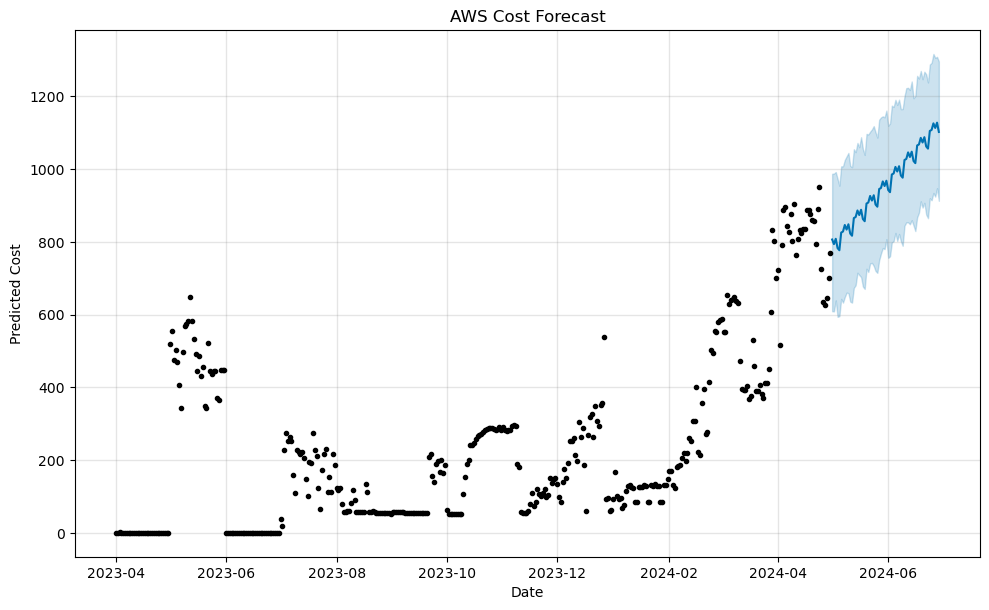

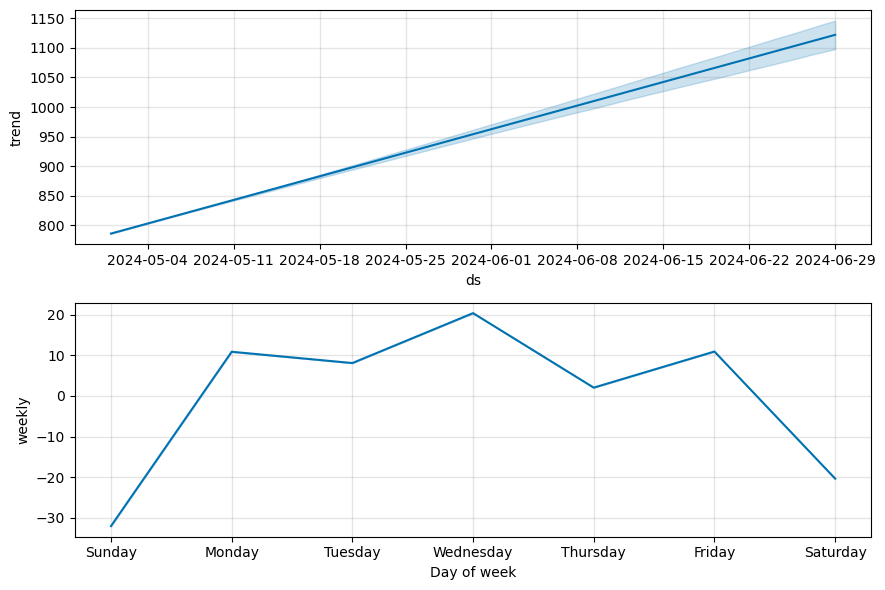

In [30]:
# # matplotlib is the simplest, but not interactive.
model.plot(forecast)
plt.xlabel("Date")
plt.ylabel("Predicted Cost")
plt.title("AWS Cost Forecast")
plt.grid(True)
plt.show()

# we'll only use MPL to plot the components
# Visualize model components (trend, seasonality, etc.)
model.plot_components(forecast)
plt.show()

In [31]:
# Plotly not very useful for components and seasonality
trends = go.Scatter(
    x=forecast["ds"],
    y=forecast["yhat"],
    mode="lines+markers",
    name="Trend",
)

# Handle weekly and yearly seasonality, if present
if "weekly" in forecast.columns:
    weekly = go.Scatter(
        x=forecast["ds"],
        y=forecast["weekly"],
        mode="lines",
        name="Weekly",
    )

if "yearly" in forecast.columns:
    yearly = go.Scatter(
        x=forecast["ds"],
        y=forecast["yearly"],
        mode="lines",
        name="Yearly",
    )

# Compose the figure
data = [trends]
if "weekly" in forecast.columns:
    data.append(weekly)
if "yearly" in forecast.columns:
    data.append(yearly)

fig_components = go.Figure(data=data)

# Customize layout
fig_components.update_layout(
    title="AWS Cost Forecast Components (Plotly)", xaxis_title="Date"
)

fig_components.show()

done.